In [1]:
from util import generate_unique_id,get_responses_for_prompt, get_bert_embeddings
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from scipy.spatial import ConvexHull
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import seaborn as sns

import hashlib

from scipy.stats import gaussian_kde

ModuleNotFoundError: No module named 'transformers'

In [2]:
gpt_models = ['gpt-3.5-turbo', 'gpt-4o', 'gemini-pro']
temperatures = [0.25, 0.5, 0.75, 1.0] #, 1.25, 1.5, 1.75, 2.0]

PLOT_FIGURES = True

In [3]:
import os

def read_prompts_from_directory(base_path, model_name):
    # Dictionary to store prompts categorized by difficulty
    categorized_prompts = {
        'easy': [],
        'moderate': [],
        'confusing': []
    }
    
    # Define the paths for each difficulty level
    difficulties = ['easy', 'moderate', 'confusing']
    
    # Traverse each difficulty level
    for difficulty in difficulties:
        difficulty_path = os.path.join(base_path, 'responses', difficulty, model_name)
        print(difficulty_path)
        if not os.path.exists(difficulty_path):
            continue
        
        for root, dirs, files in os.walk(difficulty_path):
            for file in files:
                if file.endswith("_prompt.txt"):
                    file_path = os.path.join(root, file)
                    with open(file_path, 'r') as f:
                        prompt = f.read().strip()
                        categorized_prompts[difficulty].append(prompt)
    
    # Convert sets back to lists
    for difficulty in categorized_prompts:
        categorized_prompts[difficulty] = list(dict.fromkeys(categorized_prompts[difficulty])) #list(categorized_prompts[difficulty])
        
    return categorized_prompts

# Set the base path where the folder structure is located
base_path = './'

# Read and categorize the prompts
categorized_prompts = read_prompts_from_directory(base_path, 'gpt-3.5-turbo')

# Print the number of prompts in each category for verification
print(f"Easy prompts: {len(categorized_prompts['easy'])}")
print(f"Moderate prompts: {len(categorized_prompts['moderate'])}")
print(f"Confusing prompts: {len(categorized_prompts['confusing'])}")

# Example output of prompts
for category, prompts in categorized_prompts.items():
    print(f"\n{category.capitalize()} Prompts:")
    for prompt in prompts[:5]:  # Print the first 5 prompts of each category
        print(f"- {prompt}")



./responses/easy/gpt-3.5-turbo
./responses/moderate/gpt-3.5-turbo
./responses/confusing/gpt-3.5-turbo
Easy prompts: 35
Moderate prompts: 27
Confusing prompts: 29

Easy Prompts:
- Explain the basics of the human immune system.
- Explain how airplanes stay in the air.
- Describe how the Internet transmits data across the world.
- Describe how earthquakes occur.
- Describe how a refrigerator works to keep food cold.

Moderate Prompts:
- Explain the theory of evolution by natural selection and its impact on biodiversity.
- Analyze the role of cryptography in modern communications.
- Describe the causes and effects of the Great Depression.
- Explain the process of photosynthesis and its importance to the Earth’s atmosphere.
- Explain the psychological effects of social media on teenagers.

Confusing Prompts:
- Is a broken clock right if it tells the right time twice a day?
- Explain why time dilation occurs at the quantum level as compared to macroscopic objects.
- How do you know that you 

In [4]:
def generate_unique_id(prompt):
    """Generates a unique hash for a given prompt."""
    return hashlib.sha256(prompt.encode('utf-8')).hexdigest()

# Easy Prompts

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

NameError: name 'gaussian_kde' is not defined

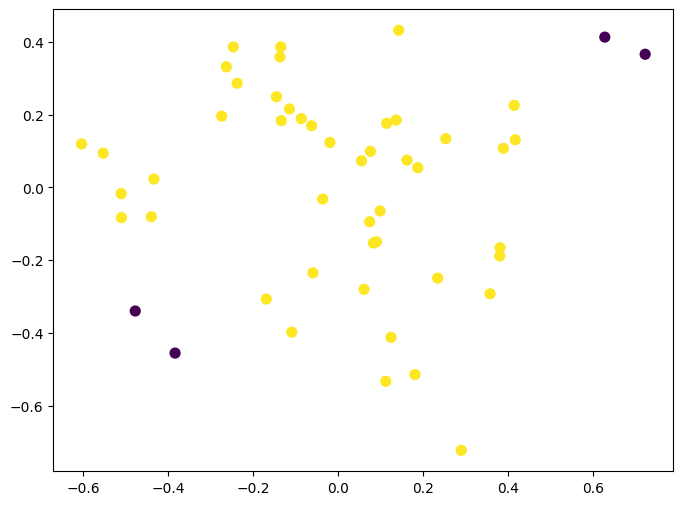

In [5]:
# Extracting prompts from categorized_prompts
easy_prompts = categorized_prompts['easy']

# Initialize DataFrame to store results
columns = ['PromptID', 'PromptType', 'Model Name', 'Num_Clusters', 'Cluster_Areas'] + [f'Convex_Hull-{t}' for t in temperatures]
results_df = pd.DataFrame(columns=columns)

# Initialize an empty list to collect rows
rows = []

for gpt_model in tqdm(gpt_models):
    for prompt in tqdm(easy_prompts, position=0, leave=True):
        row = {'PromptID': generate_unique_id(prompt), 'PromptType': 'Easy', 'Model Name': gpt_model}

        for temperature in temperatures:
            responses = get_responses_for_prompt(prompt, 'easy', gpt_model, temperature)
            if not responses:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            embeddings = np.array([get_bert_embeddings(response) for response in responses])

            if embeddings.shape[0] < 10:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            # Dimensionality Reduction
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings)

            if embeddings_2d.shape[0] < 10:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            # Clustering with DBSCAN
            dbscan = DBSCAN(eps=0.25 * temperature * 4.0, min_samples=3)
            labels = dbscan.fit_predict(embeddings_2d)

            unique_labels = set(labels)
            hull_volumes = []
            total_hull_area = 0
            num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            
            if PLOT_FIGURES:
                plt.figure(figsize=(8, 6))
                plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', zorder=10, s=50)

                # Calculate the point density
                x = embeddings_2d[:, 0]
                y = embeddings_2d[:, 1]
                xy = np.vstack([x, y])
                z = gaussian_kde(xy)(xy)

                # Create a contour plot
                xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
                xi, yi = np.meshgrid(xi, yi)
                zi = gaussian_kde(xy)(np.vstack([xi.flatten(), yi.flatten()]))

                plt.contourf(xi, yi, zi.reshape(xi.shape), levels=15, cmap='viridis')
                plt.colorbar(label='Density')

                plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', zorder=10, s=50)

            for label in unique_labels:
                if label == -1:
                    continue
                cluster_indices = [idx for idx, l in enumerate(labels) if l == label]
                cluster_points = embeddings_2d[cluster_indices]

                if len(np.unique(cluster_points, axis=0)) > 2:
                    hull = ConvexHull(cluster_points)
                    hull_area = hull.volume
                    hull_volumes.append(hull_area)
                    total_hull_area += hull_area
                    if PLOT_FIGURES:
                        for simplex in hull.simplices:
                             plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'w--')
                        plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], alpha=0.3)

            if PLOT_FIGURES:
                hull_volumes_str = ', '.join(f'Cluster {label}: {volume:.2f}' for label, volume in zip(unique_labels, hull_volumes) if label != -1)
                #plt.title(f'Convex Hulls for Clusters\nImage: {image}\n{hull_volumes_str}\nTotal Area: {total_hull_area:.2f}')
                #plt.xlabel('Component 1')
                #plt.ylabel('Component 2')
                plt.grid(True)
                plt.savefig(f"img/{image}-hull.pdf",bbox_inches='tight')
                plt.show()

            row[f'Convex_Hull-{temperature}'] = total_hull_area

        row['Num_Clusters'] = num_clusters
        row['Cluster_Areas'] = hull_volumes
        rows.append(row)

# Concatenate rows into a DataFrame
results_df = pd.concat([results_df, pd.DataFrame(rows)], ignore_index=True)

# Save results to a CSV file
results_df.to_csv('convex_hull_results-easy.csv', index=False)

In [ ]:
results_df.to_csv('convex_hull_results-easy.csv', index=False, mode='w')

In [ ]:
results_df

In [ ]:
# results_df.to_csv('convex_hull_results-easy.csv', index=False)
results_df = pd.read_csv('convex_hull_results-easy.csv')#, index=False)

# Convert DataFrame to long format
results_long_df = pd.melt(results_df, id_vars=['PromptID', 'PromptType', 'Model Name', 'Num_Clusters', 'Cluster_Areas'], 
                          var_name='Temperature', value_name='Convex_Hull')

# Extract the temperature values from the column names
results_long_df['Temperature'] = results_long_df['Temperature'].str.extract(r'Convex_Hull-(.*)').astype(float)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_long_df, x='Temperature', y='Convex_Hull', hue='Model Name', marker='o')

#plt.title('Convex Hull Volume vs Temperature')
plt.xlabel('Temperature', fontsize=20)
plt.ylabel('Uncertainty Value', fontsize=20)
legend = plt.legend(title='Prompt ID', bbox_to_anchor=(0.01, 1), loc='upper left', fontsize="20")
plt.setp(legend.get_title(),fontsize=20)
#plt.ylim(0,11)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('easy-unc.pdf', bbox_inches='tight')
plt.show()


In [ ]:
results_long_df

# Moderate Prompts

In [ ]:
# Extracting prompts from categorized_prompts
moderate_prompts = categorized_prompts['moderate']

# Initialize DataFrame to store results
columns = ['PromptID', 'PromptType', 'Model Name', 'Num_Clusters', 'Cluster_Areas'] + [f'Convex_Hull-{t}' for t in temperatures]
results_df = pd.DataFrame(columns=columns)

# Initialize an empty list to collect rows
rows = []

for gpt_model in tqdm(gpt_models):
    for prompt in tqdm(moderate_prompts, position=0, leave=True):
        row = {'PromptID': generate_unique_id(prompt), 'PromptType': 'moderate', 'Model Name': gpt_model}

        for temperature in temperatures:
            responses = get_responses_for_prompt(prompt, 'moderate', gpt_model, temperature)
            if not responses:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            embeddings = np.array([get_bert_embeddings(response) for response in responses])

            if embeddings.shape[0] < 10:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            # Dimensionality Reduction
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings)

            if embeddings_2d.shape[0] < 10:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            # Clustering with DBSCAN
            dbscan = DBSCAN(eps=0.25 * temperature * 4.0, min_samples=3)
            labels = dbscan.fit_predict(embeddings_2d)

            unique_labels = set(labels)
            hull_volumes = []
            total_hull_area = 0
            num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

            if PLOT_FIGURES:
                plt.figure(figsize=(8, 6))
                plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', zorder=10, s=50)

            for label in unique_labels:
                if label == -1:
                    continue
                cluster_indices = [idx for idx, l in enumerate(labels) if l == label]
                cluster_points = embeddings_2d[cluster_indices]

                if len(np.unique(cluster_points, axis=0)) > 2:
                    hull = ConvexHull(cluster_points)
                    hull_area = hull.volume
                    hull_volumes.append(hull_area)
                    total_hull_area += hull_area
                    if PLOT_FIGURES:
                        for simplex in hull.simplices:
                            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-')
                        plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], alpha=0.3)

            if PLOT_FIGURES:
                hull_volumes_str = ', '.join(f'Cluster {label}: {volume:.2f}' for label, volume in zip(unique_labels, hull_volumes) if label != -1)
                plt.title(f'Convex Hulls for Clusters at Temperature {temperature}\nPrompt: {prompt}\n{hull_volumes_str}\nTotal Area: {total_hull_area:.2f}')
                plt.xlabel('Component 1')
                plt.ylabel('Component 2')
                plt.grid(True)
                plt.show()

            row[f'Convex_Hull-{temperature}'] = total_hull_area

        row['Num_Clusters'] = num_clusters
        row['Cluster_Areas'] = hull_volumes
        rows.append(row)

# Concatenate rows into a DataFrame
results_df = pd.concat([results_df, pd.DataFrame(rows)], ignore_index=True)

# Save results to a CSV file
results_df.to_csv('convex_hull_results-moderate.csv', index=False)

In [ ]:
results_df

In [ ]:
results_df = pd.read_csv('convex_hull_results-moderate.csv')#, index=False)
# Convert DataFrame to long format
results_long_df = pd.melt(results_df, id_vars=['PromptID', 'PromptType', 'Model Name', 'Num_Clusters', 'Cluster_Areas'], 
                          var_name='Temperature', value_name='Convex_Hull')

# Extract the temperature values from the column names
results_long_df['Temperature'] = results_long_df['Temperature'].str.extract(r'Convex_Hull-(.*)').astype(float)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_long_df, x='Temperature', y='Convex_Hull', hue='Model Name', marker='o')

#plt.title('Convex Hull Volume vs Temperature')
plt.xlabel('Temperature', fontsize=20)
plt.ylabel('Uncertainty Value', fontsize=20)
legend = plt.legend(title='Prompt ID', bbox_to_anchor=(0.01, 1), loc='upper left', fontsize="20")
plt.setp(legend.get_title(),fontsize=20)
#plt.ylim(0,11)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('moderate-unc.pdf', bbox_inches='tight')
plt.show()


# Confusing Prompts

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

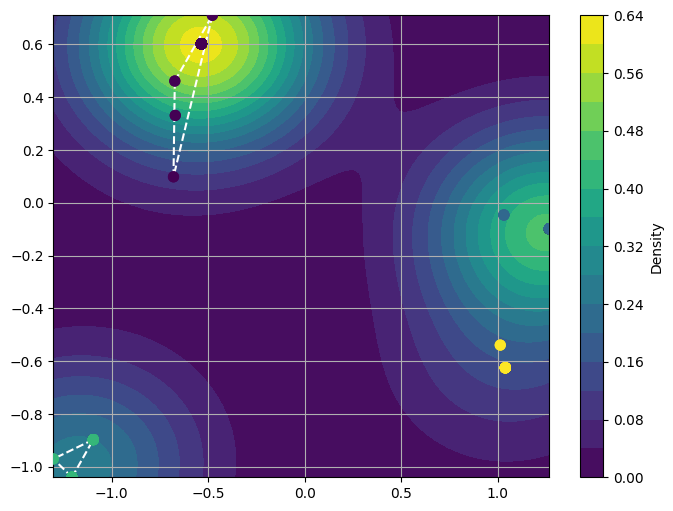

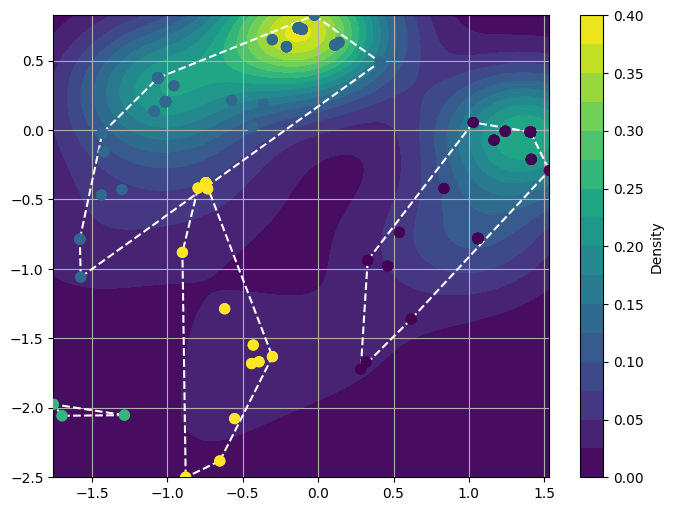

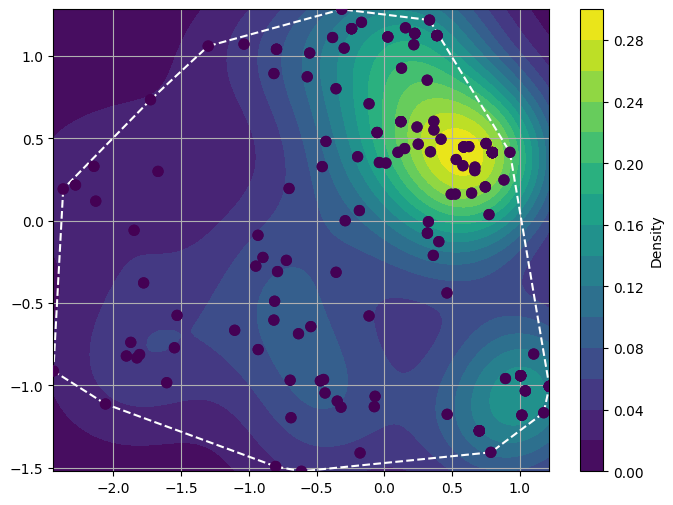

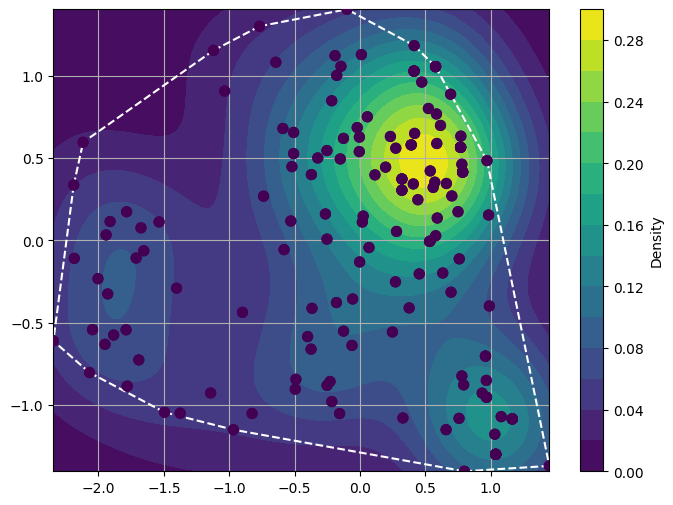

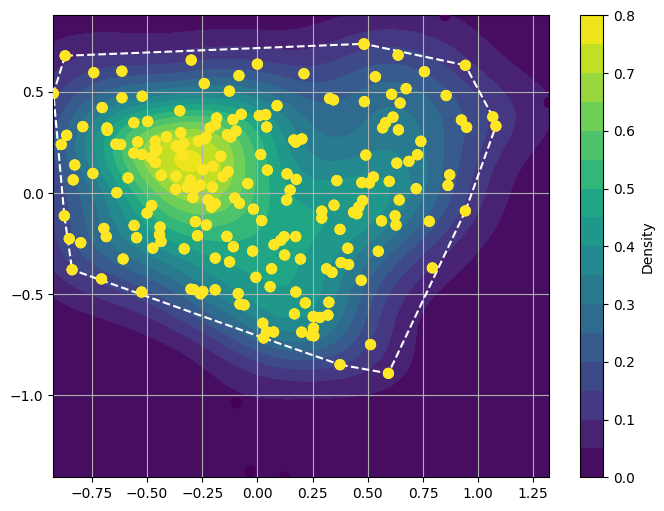

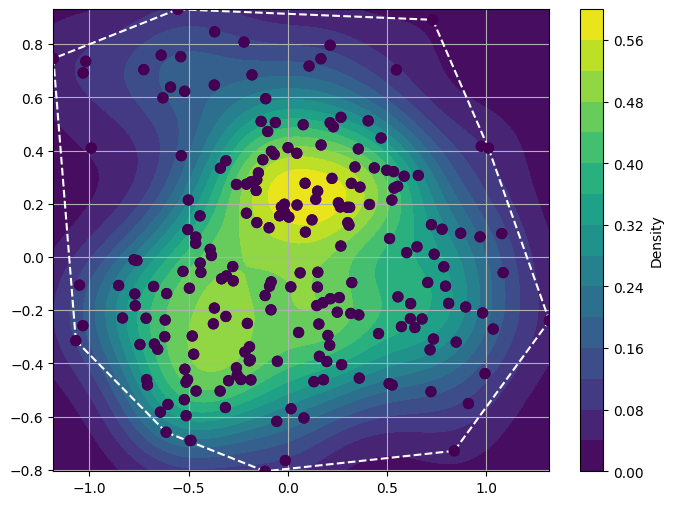

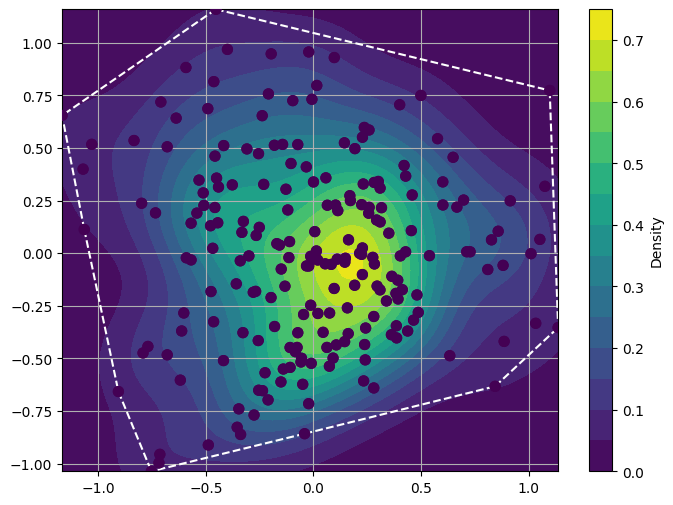

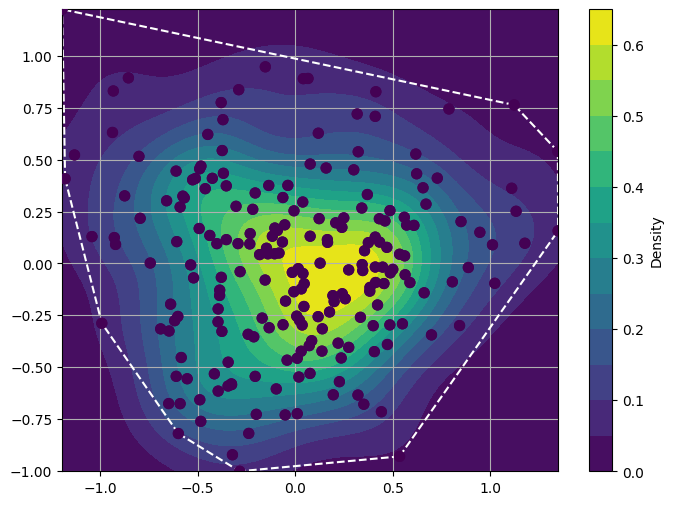

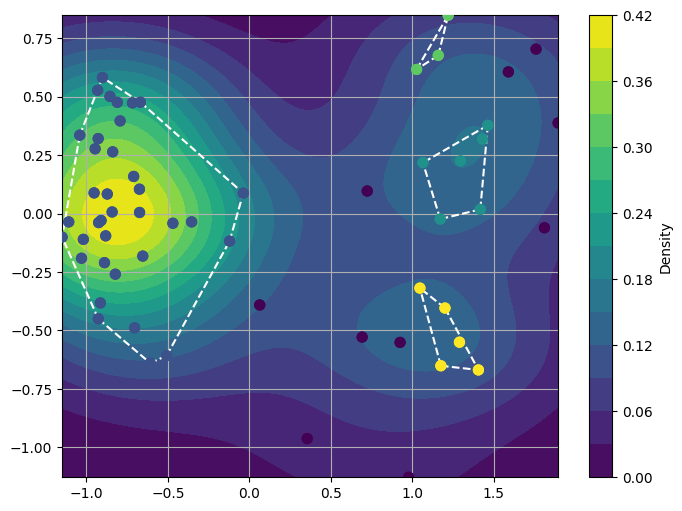

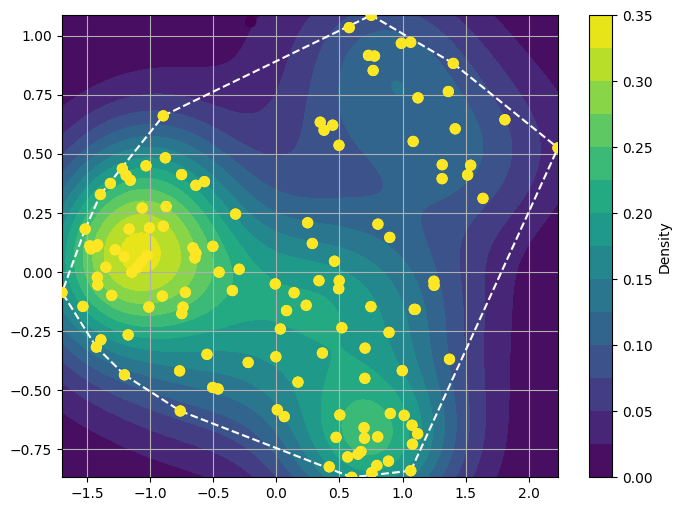

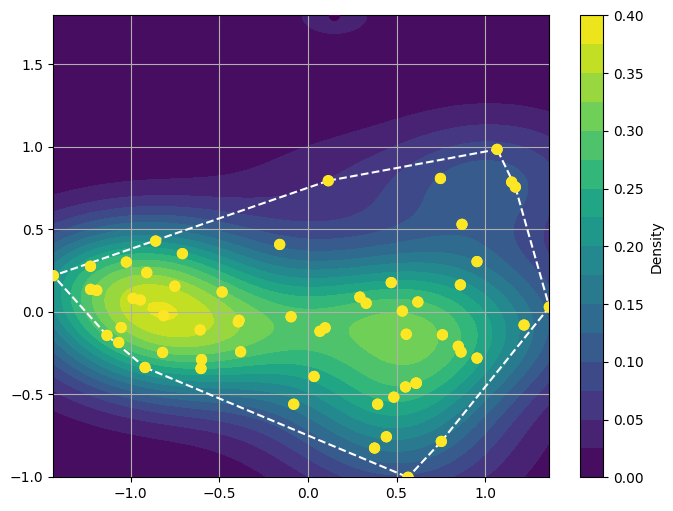

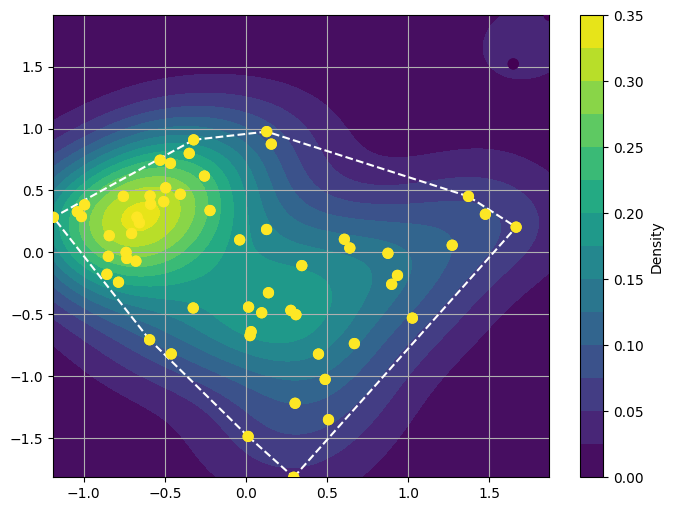

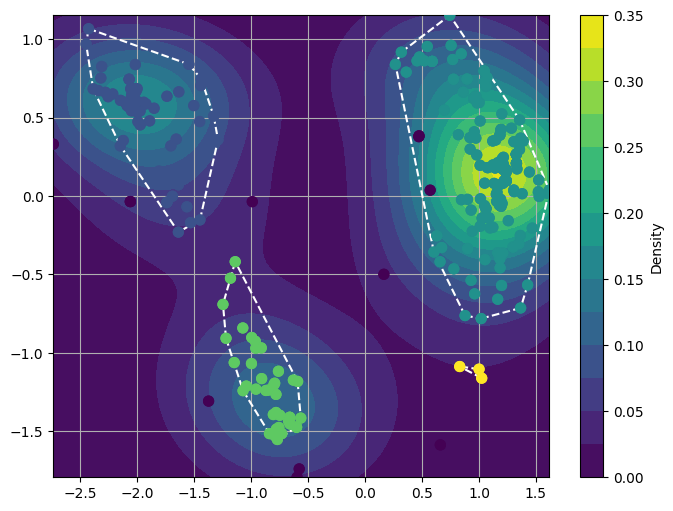

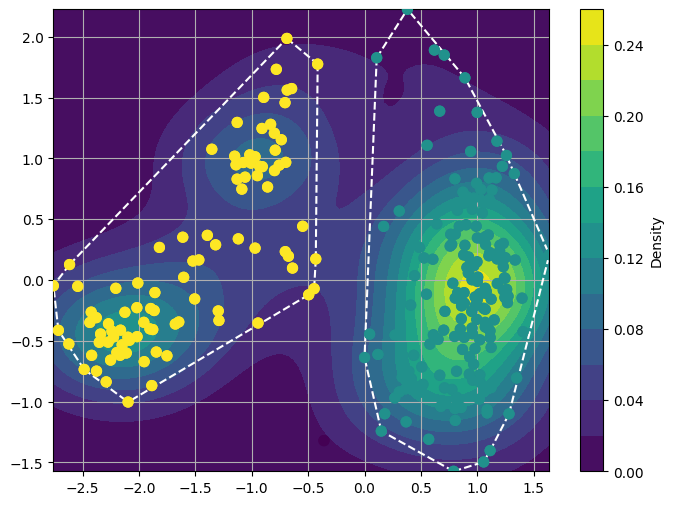

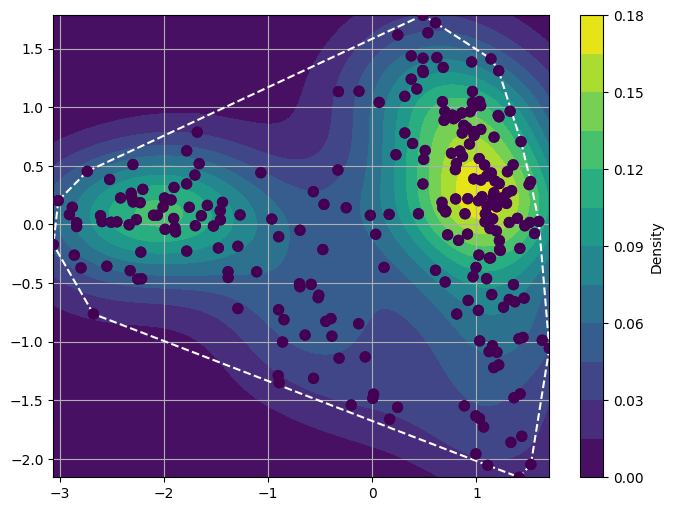

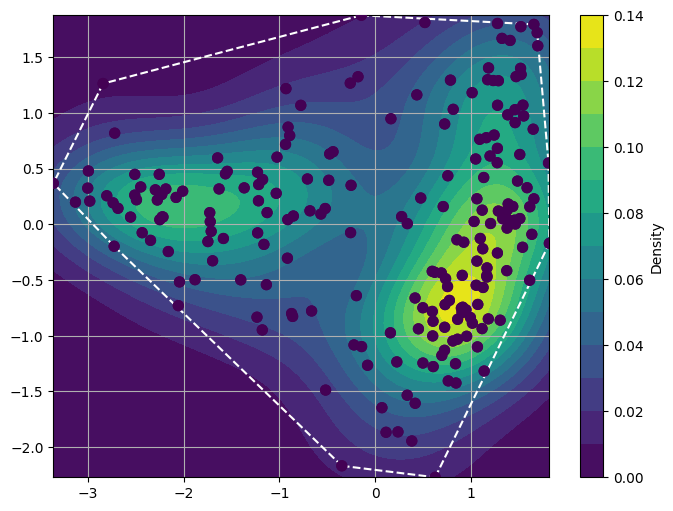

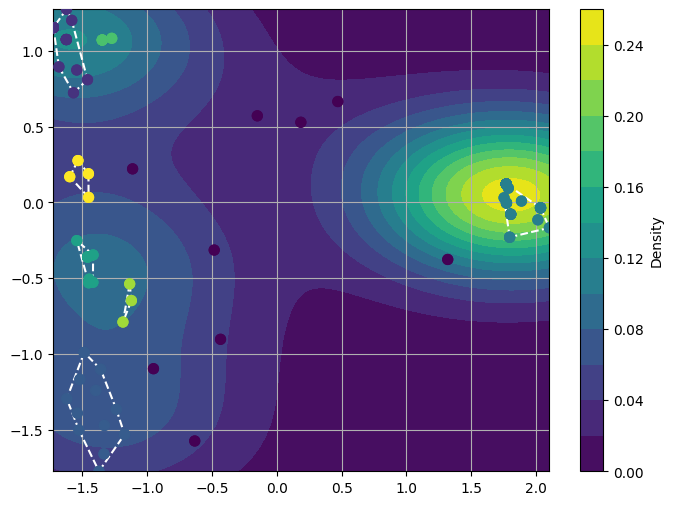

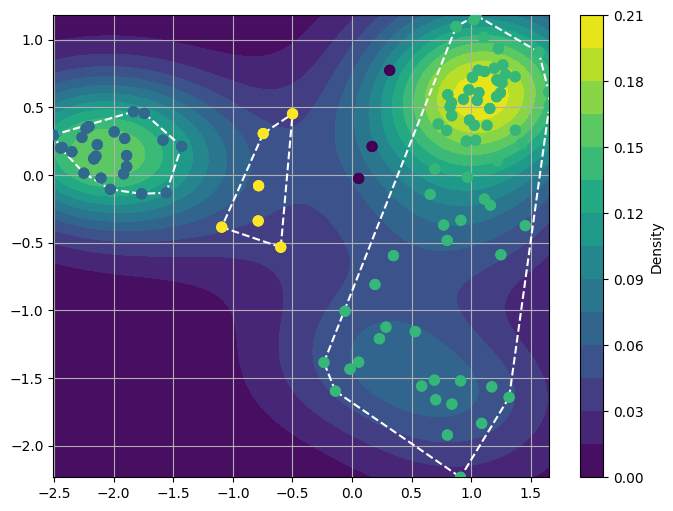

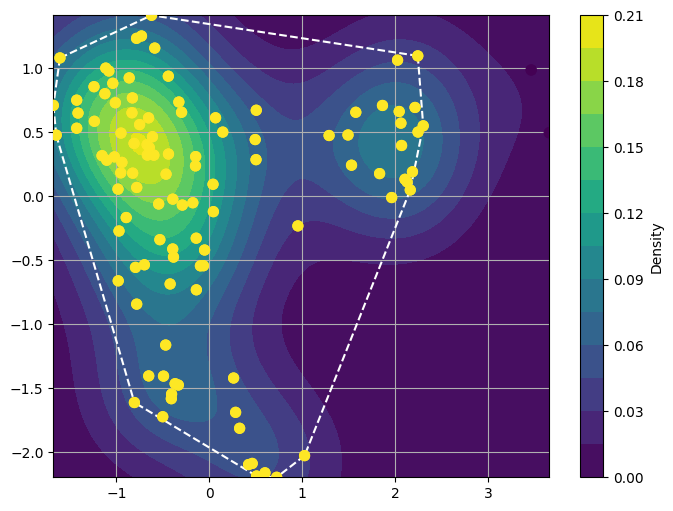

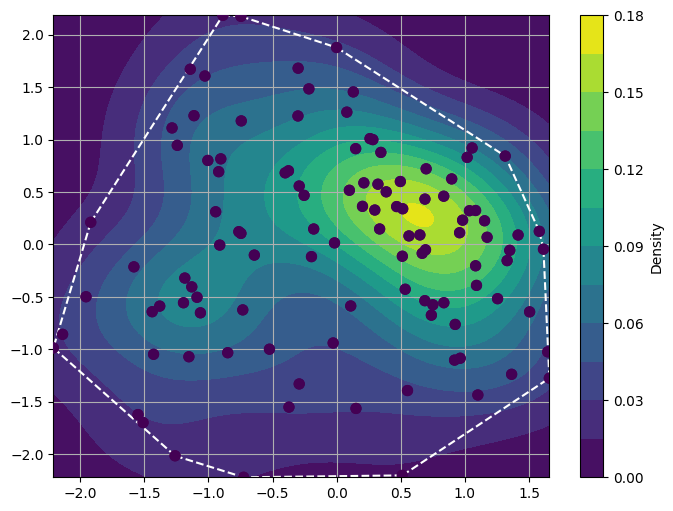

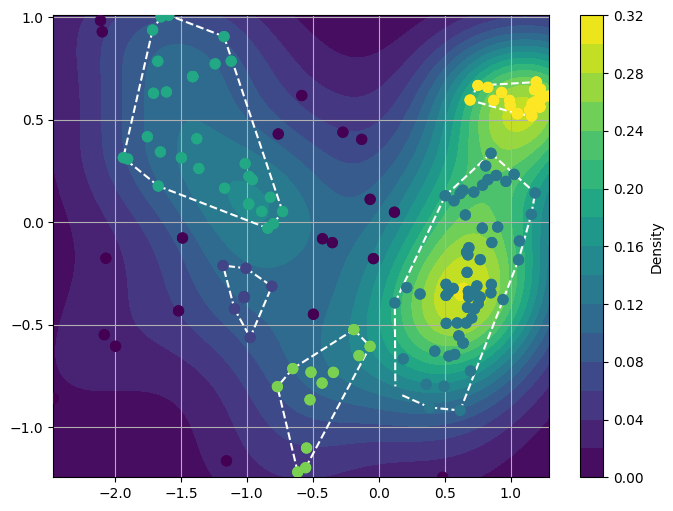

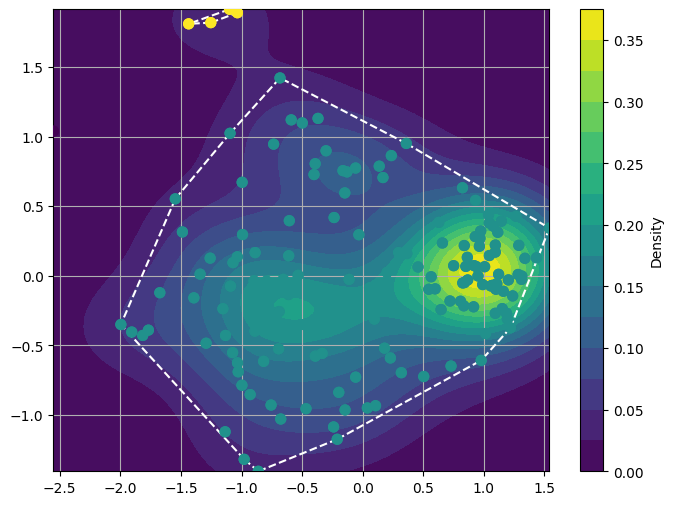

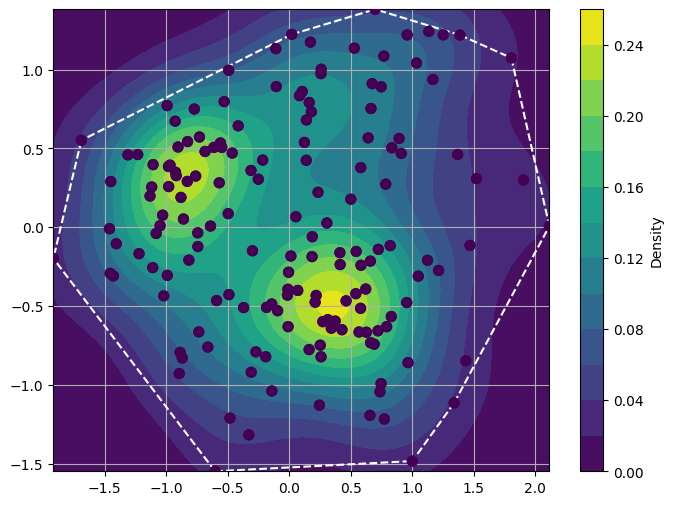

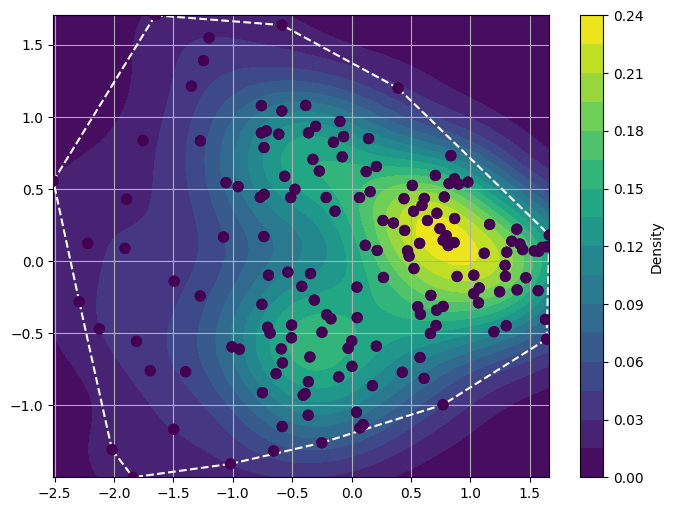

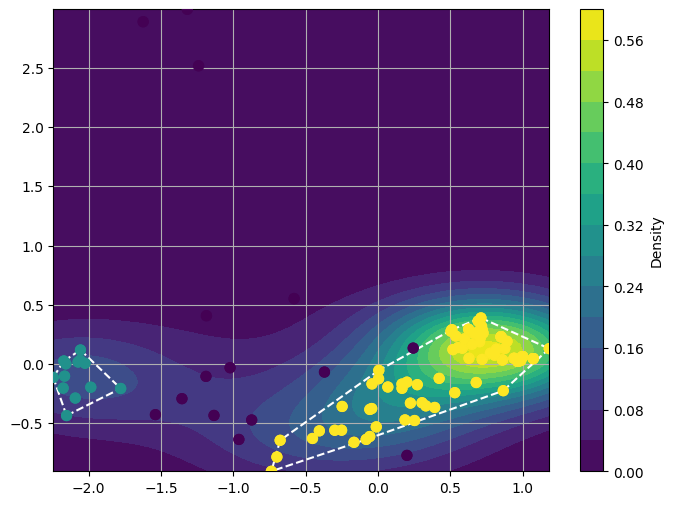

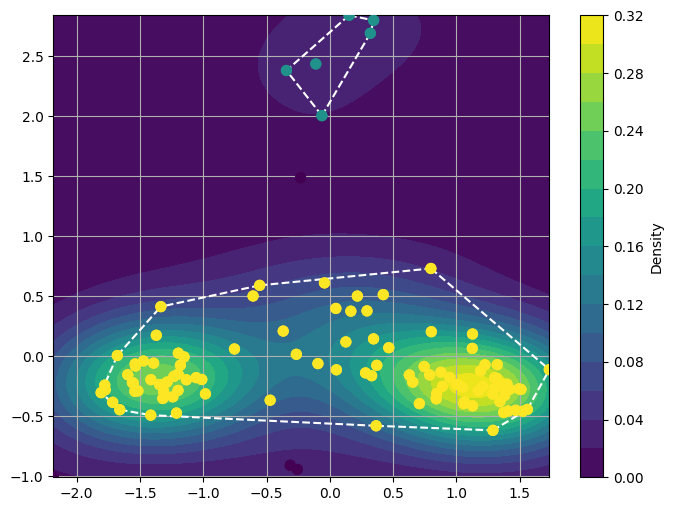

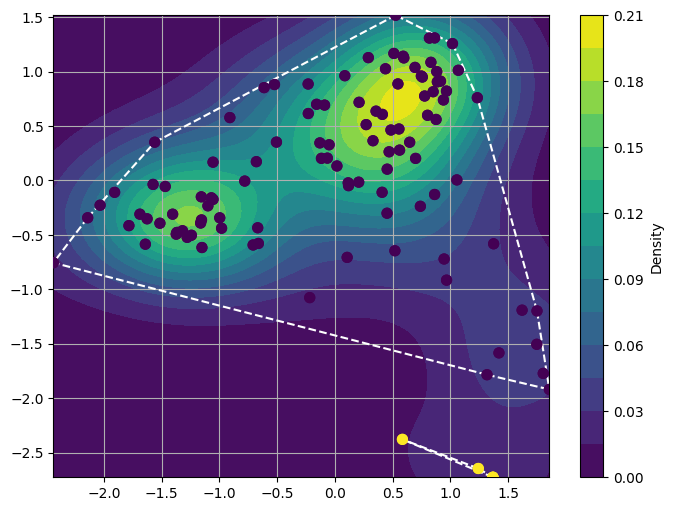

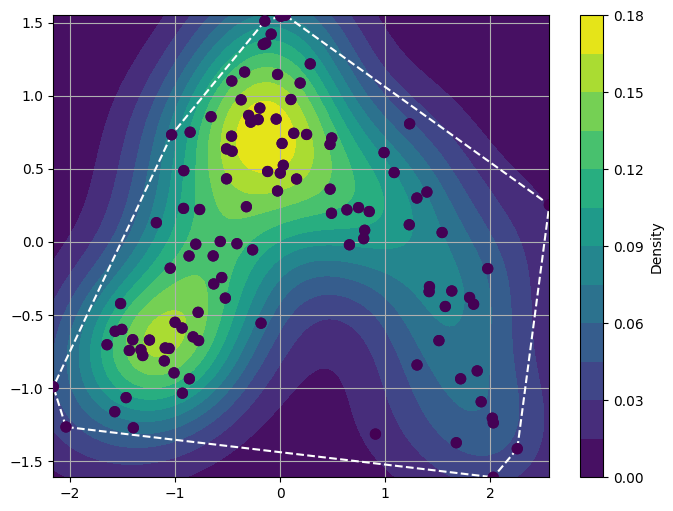

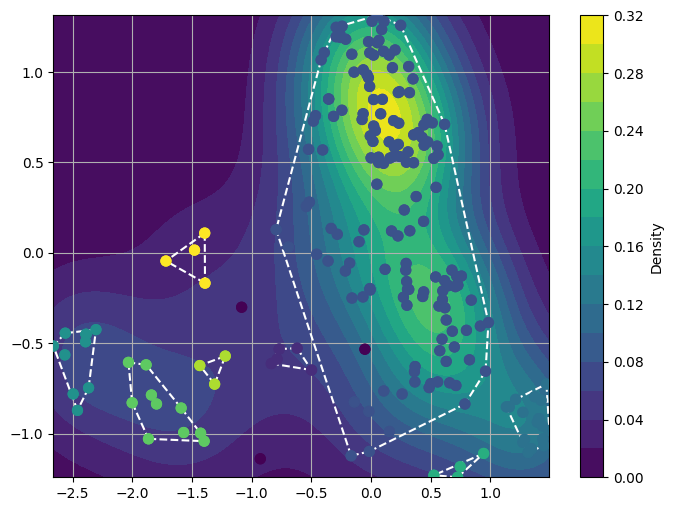

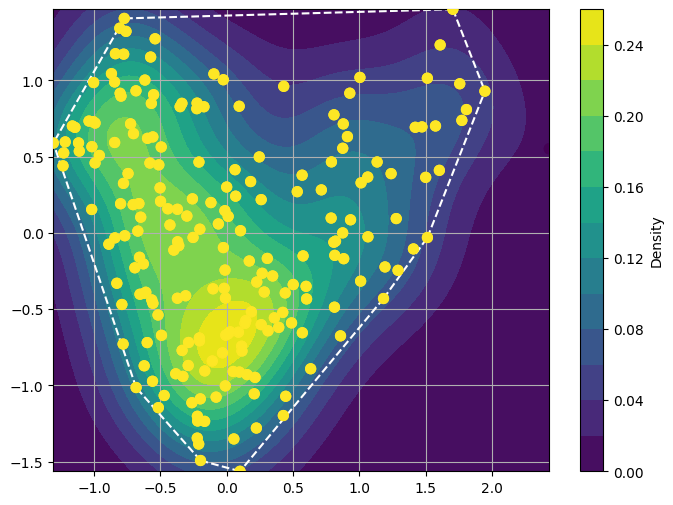

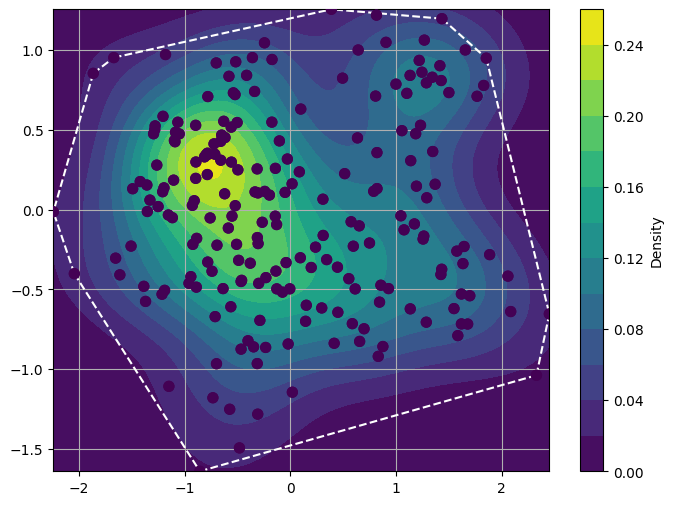

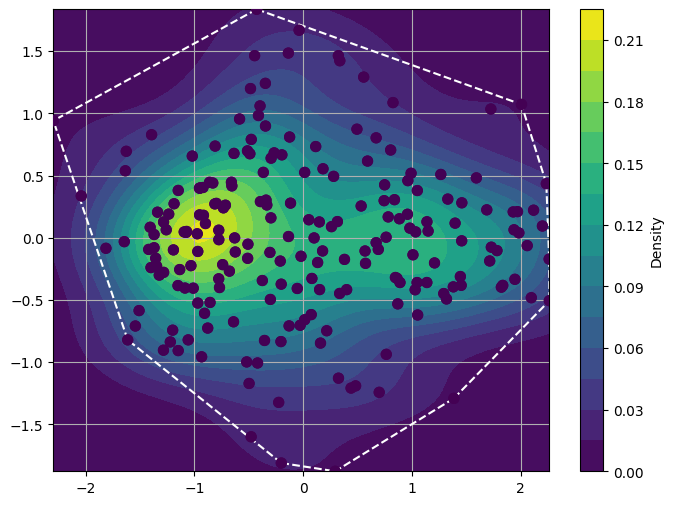

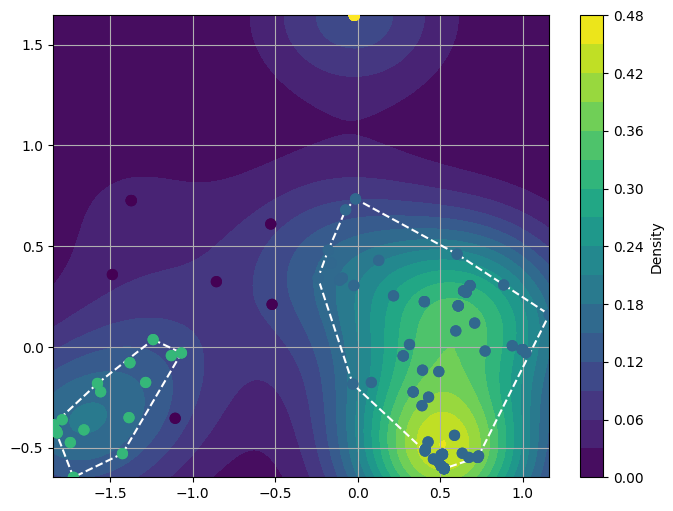

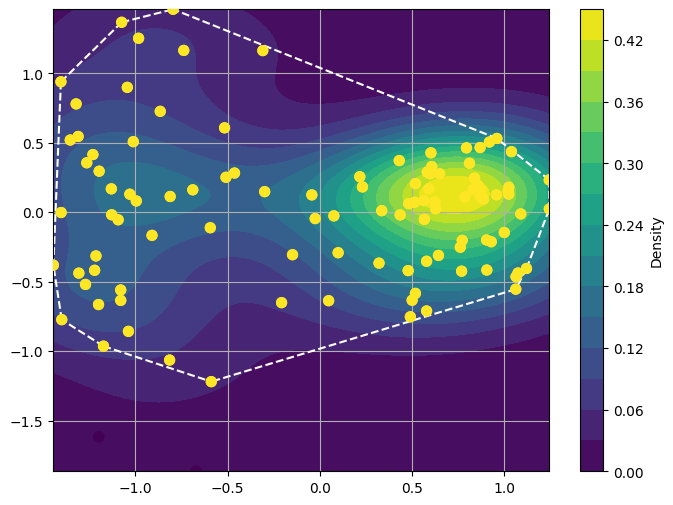

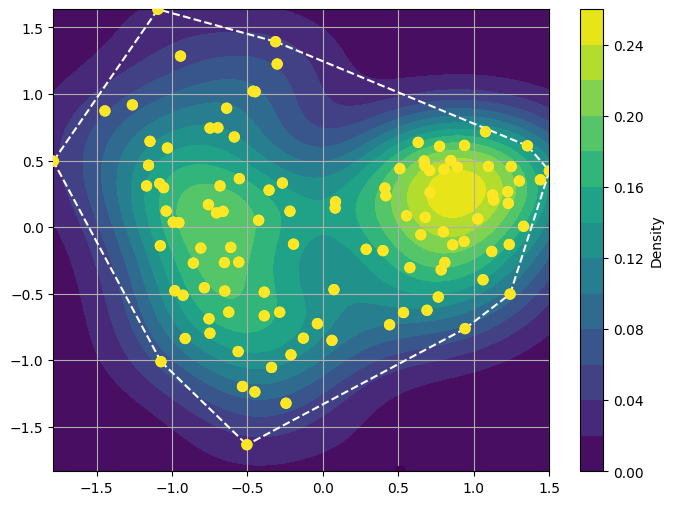

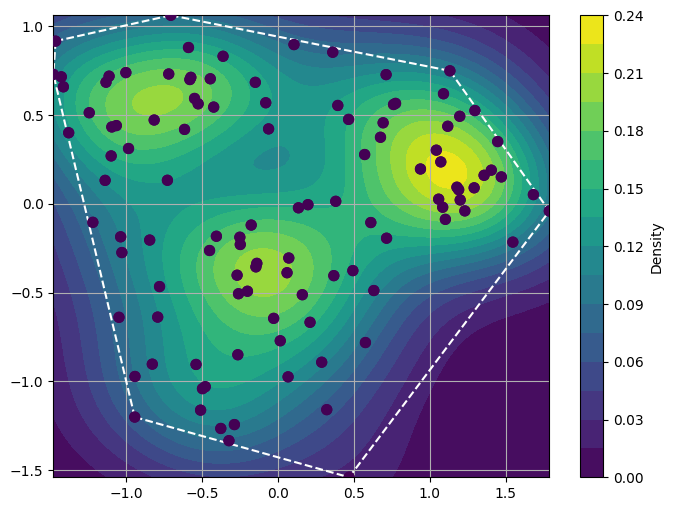

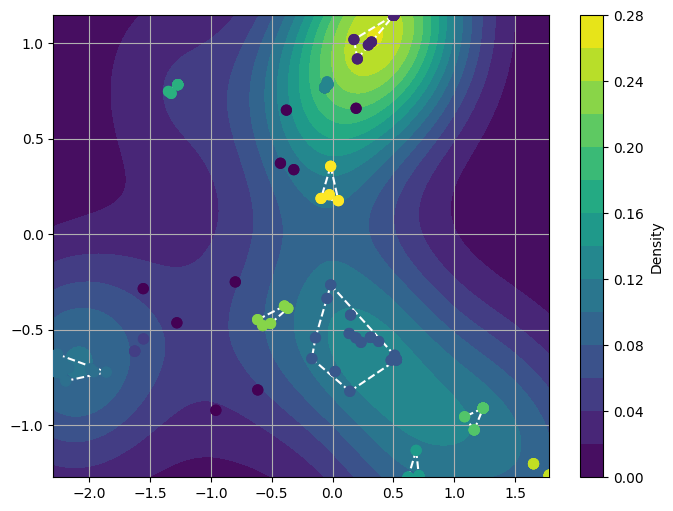

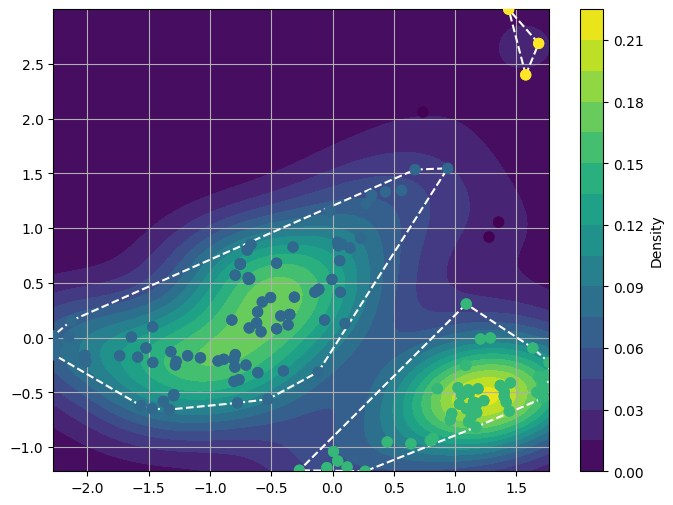

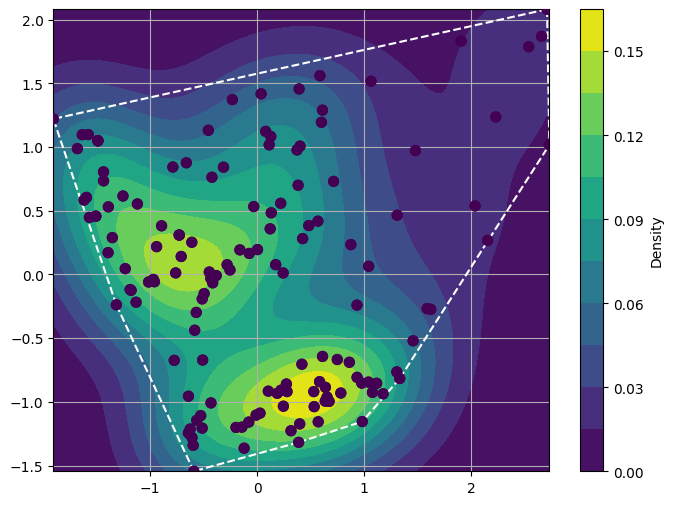

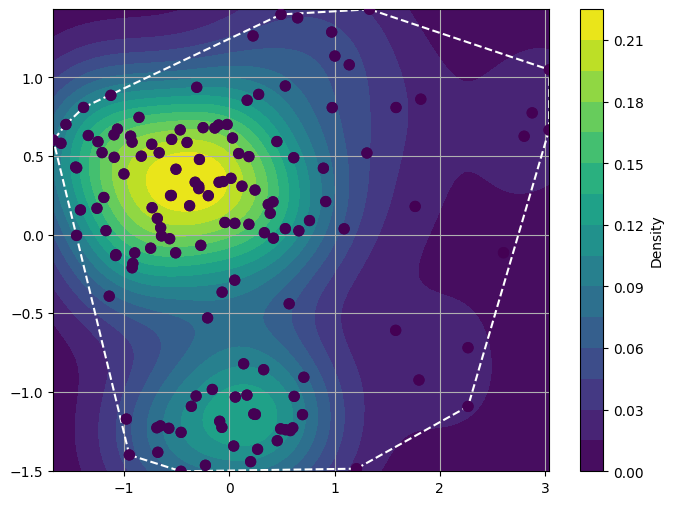

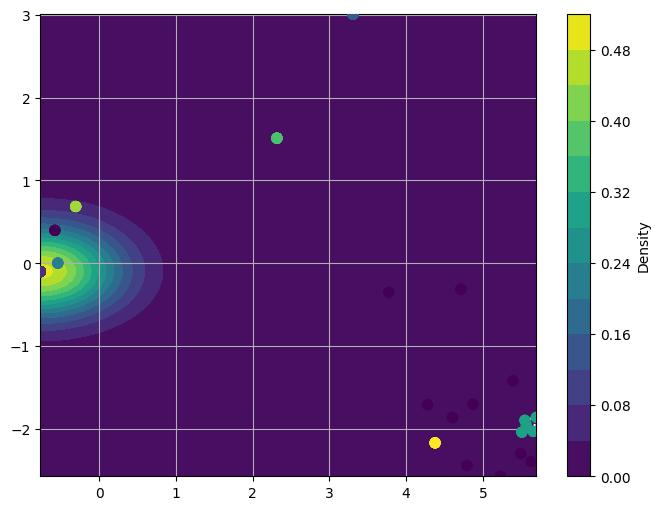

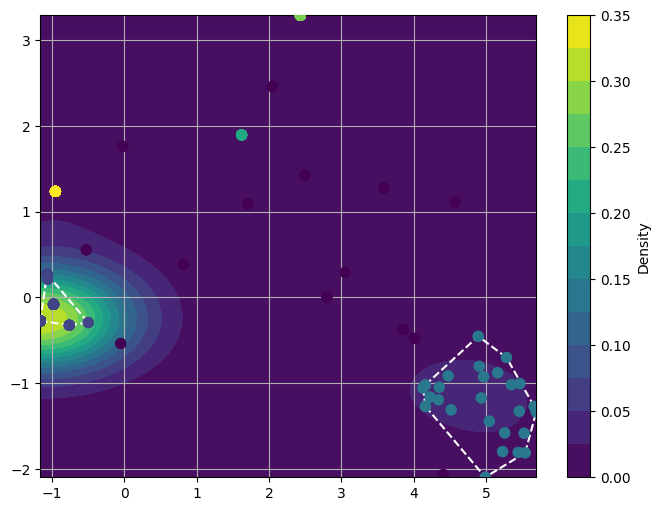

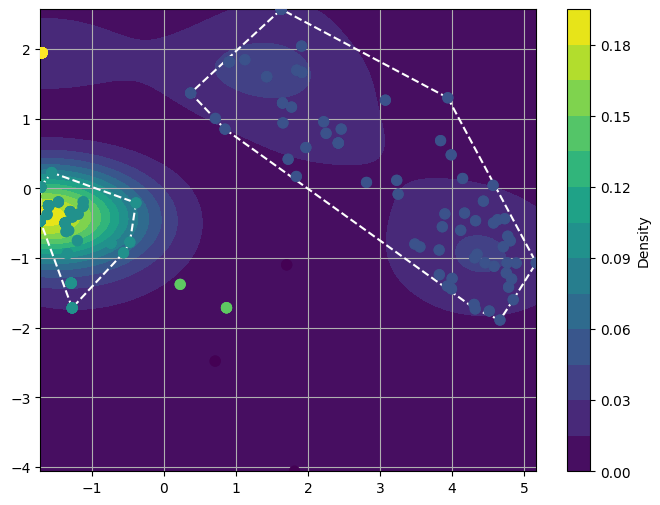

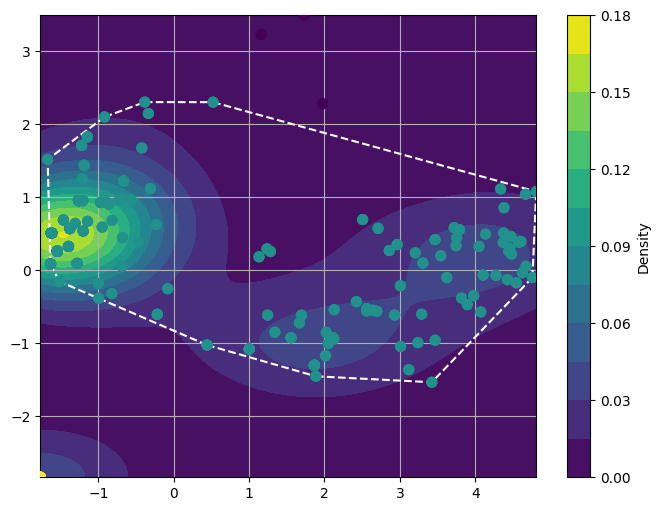

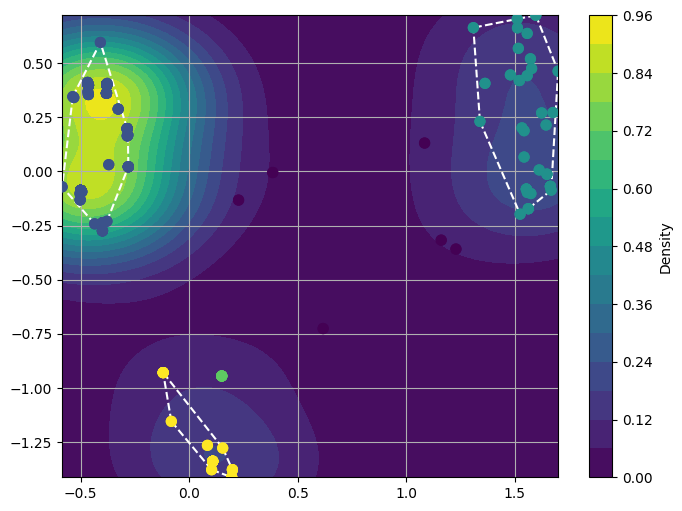

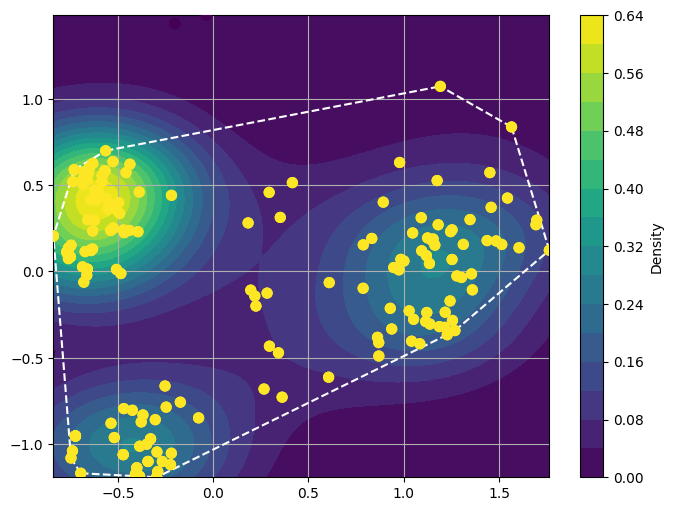

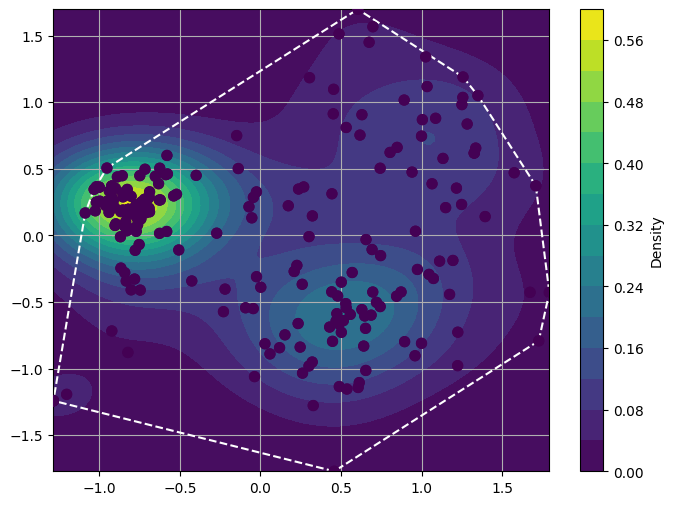

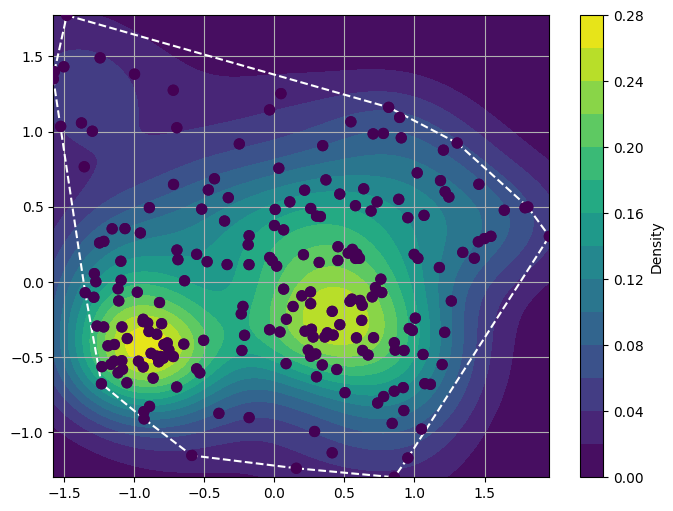

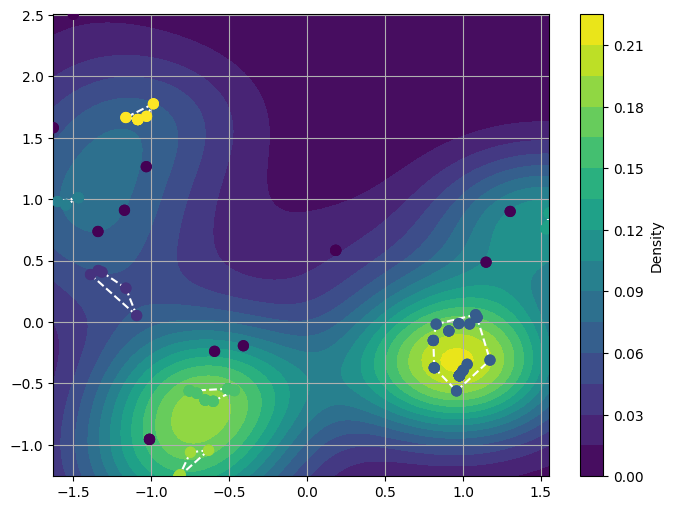

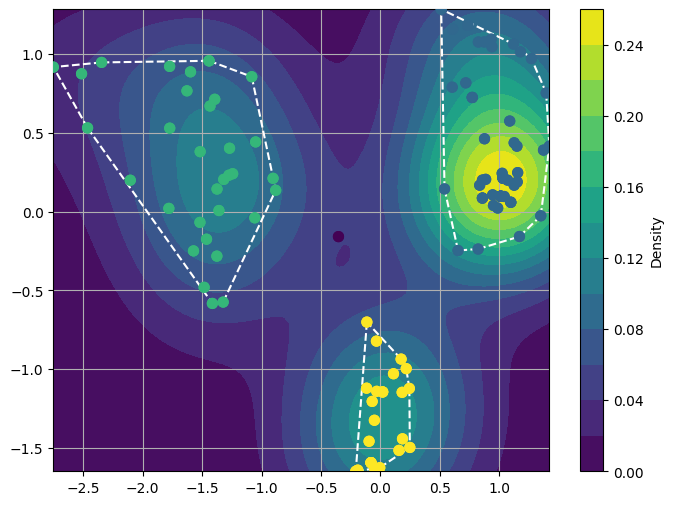

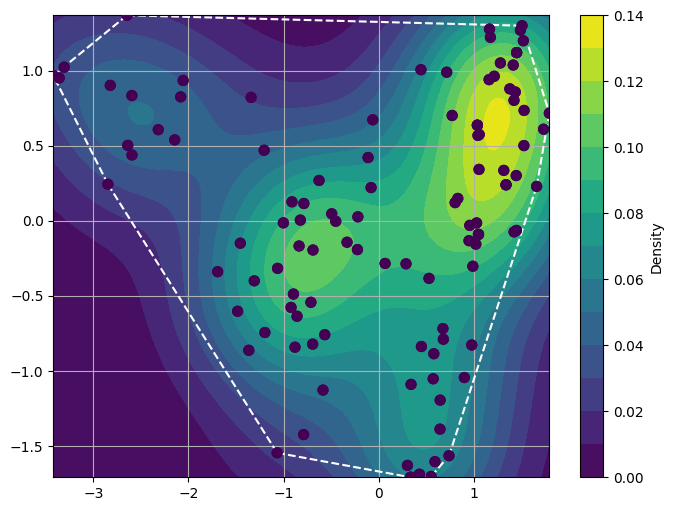

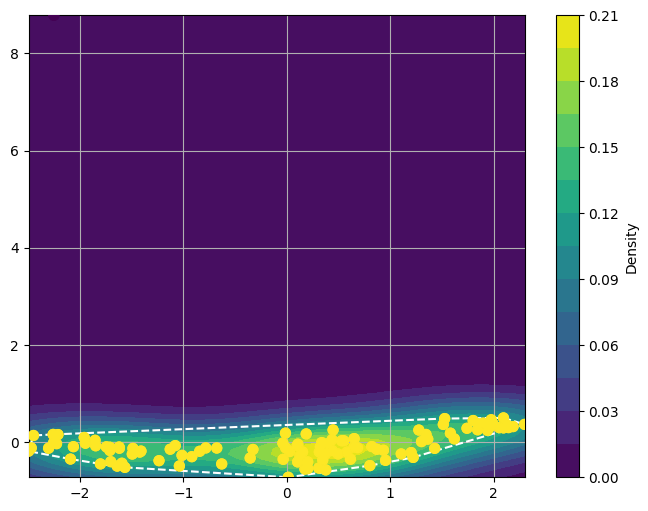

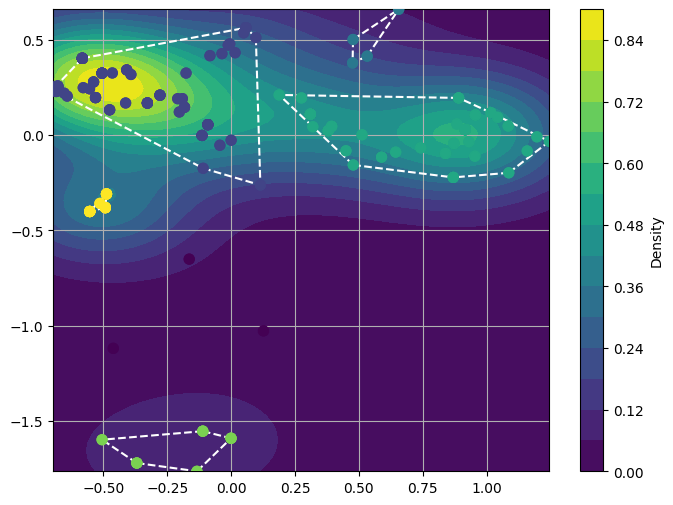

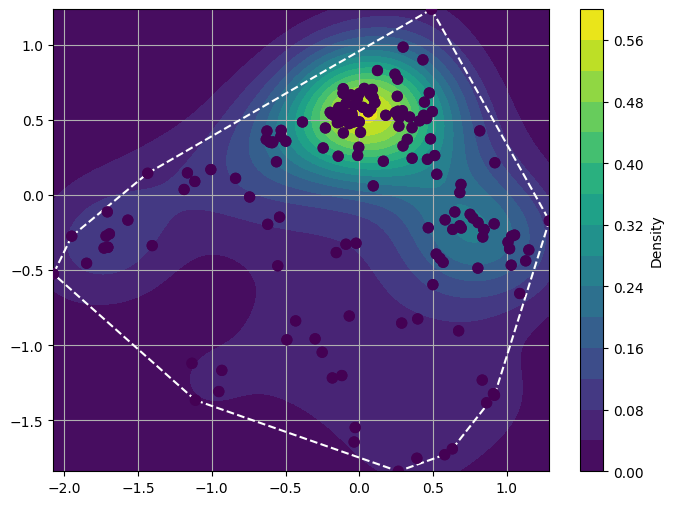

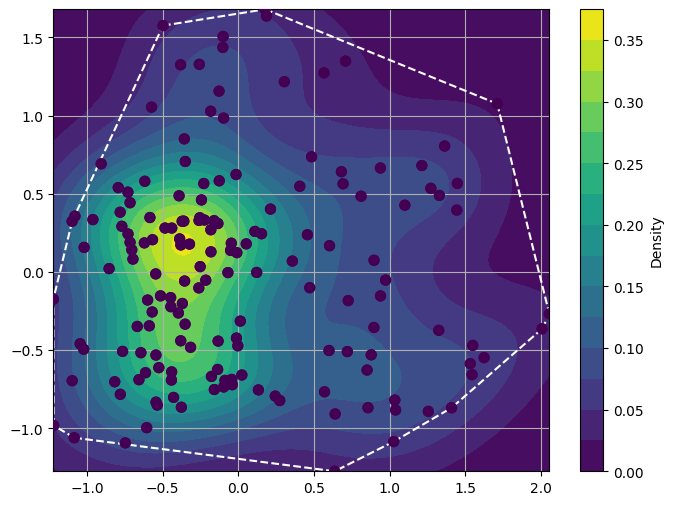

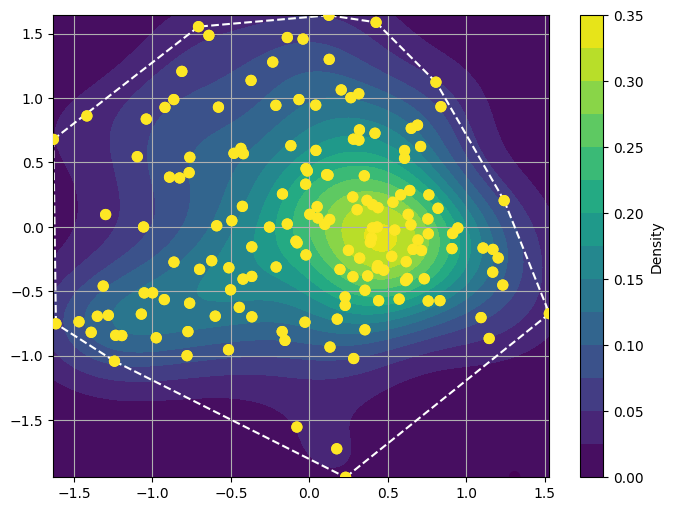

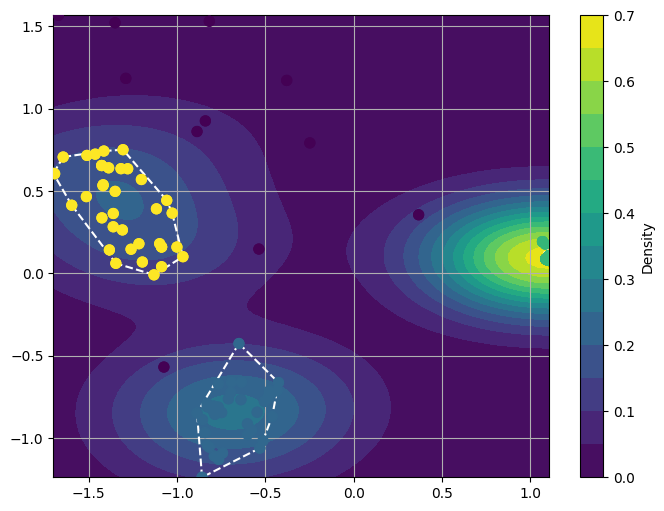

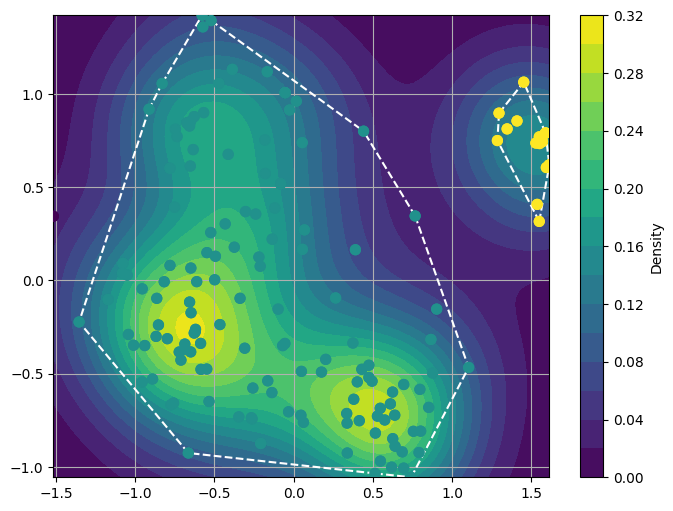

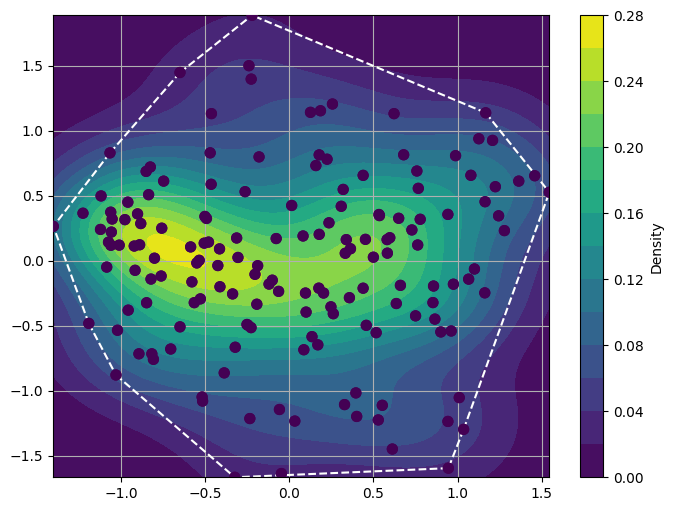

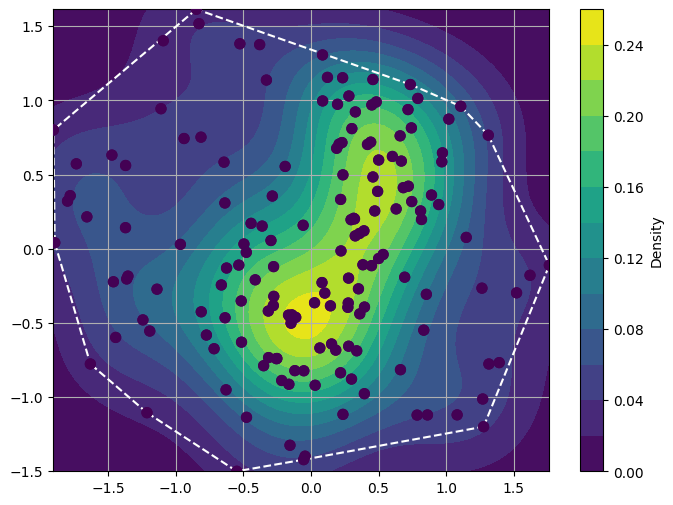

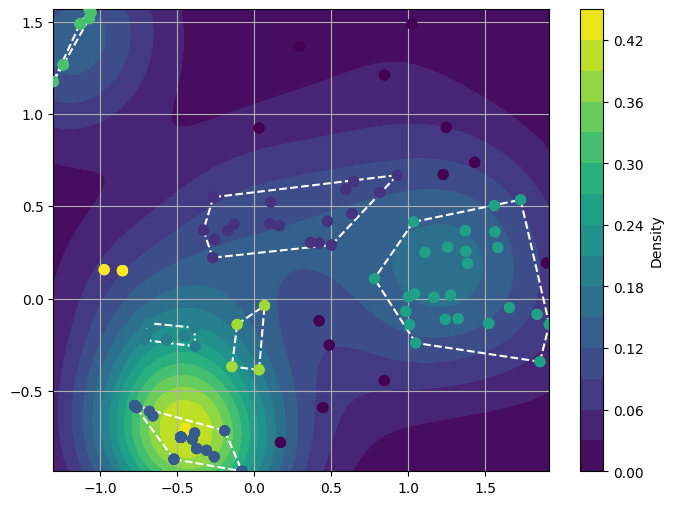

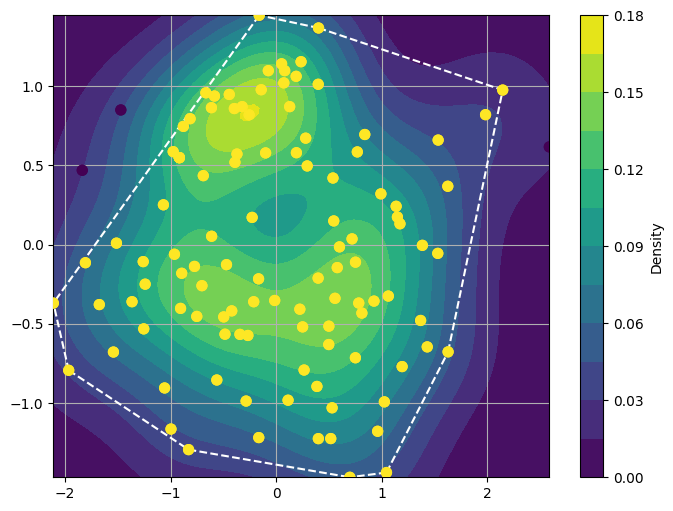

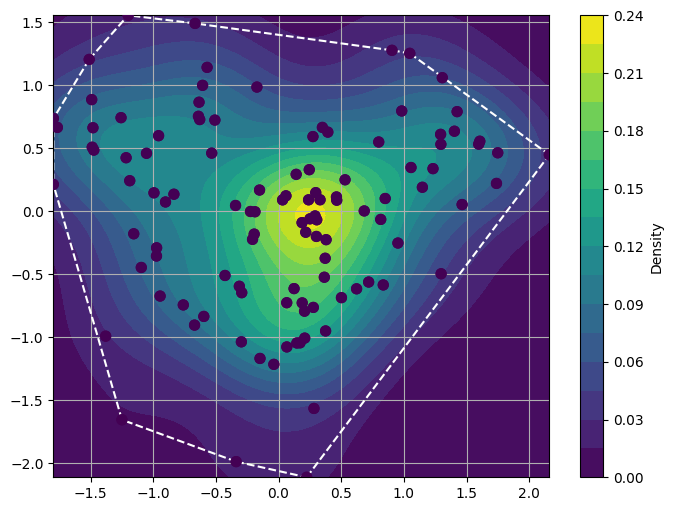

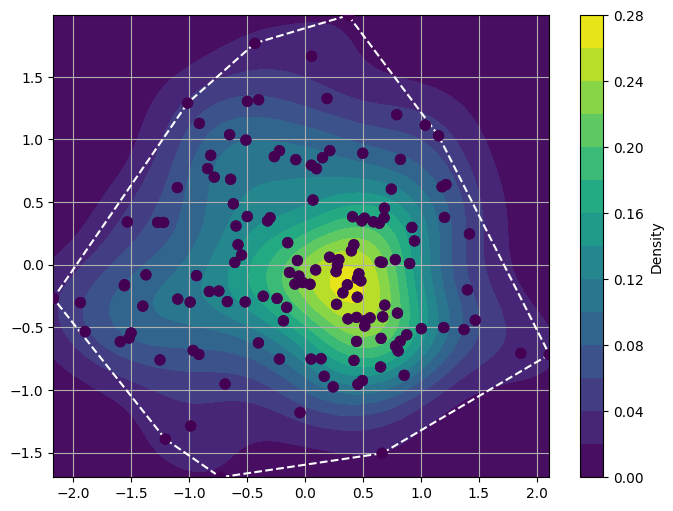

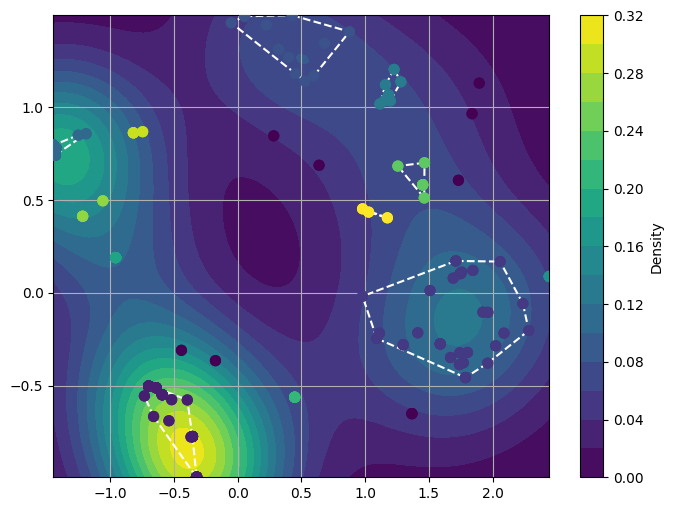

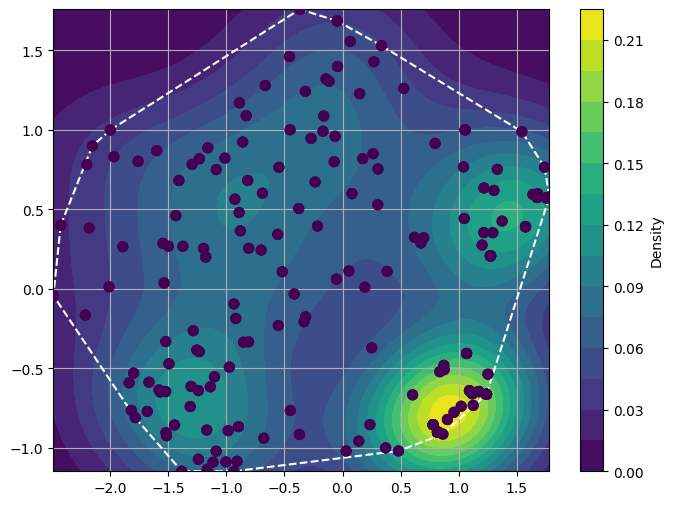

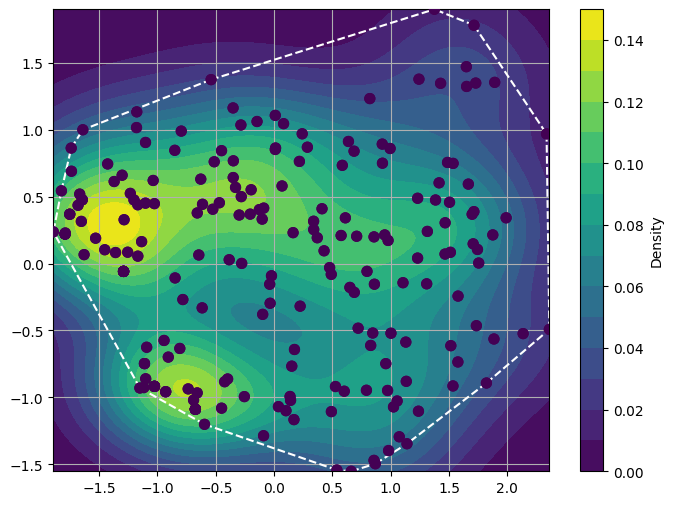

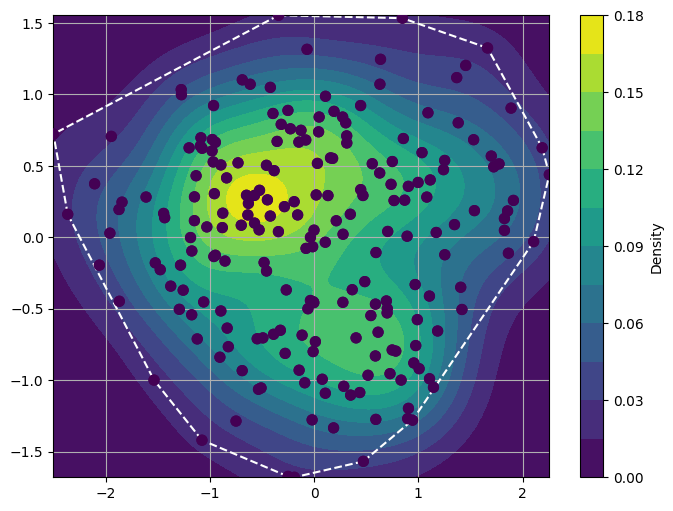

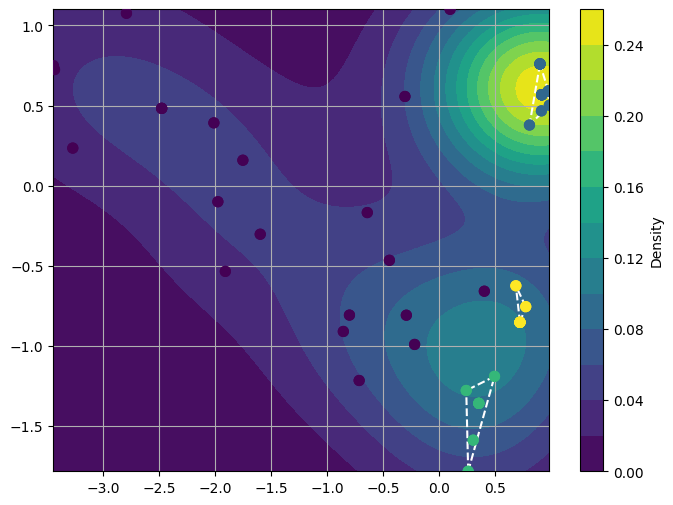

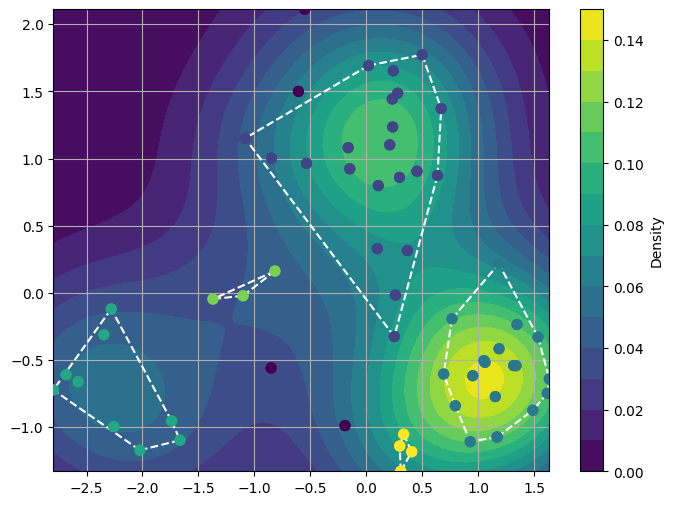

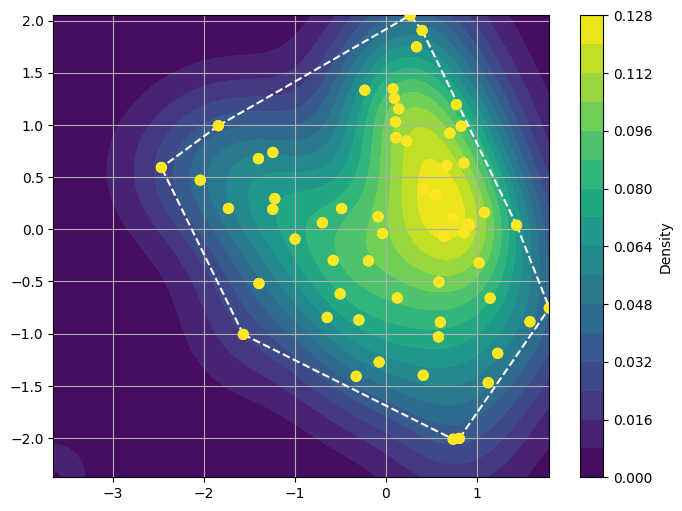

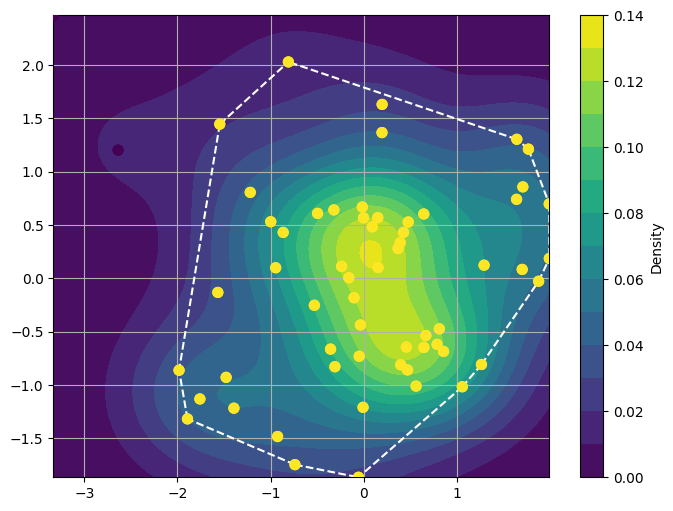

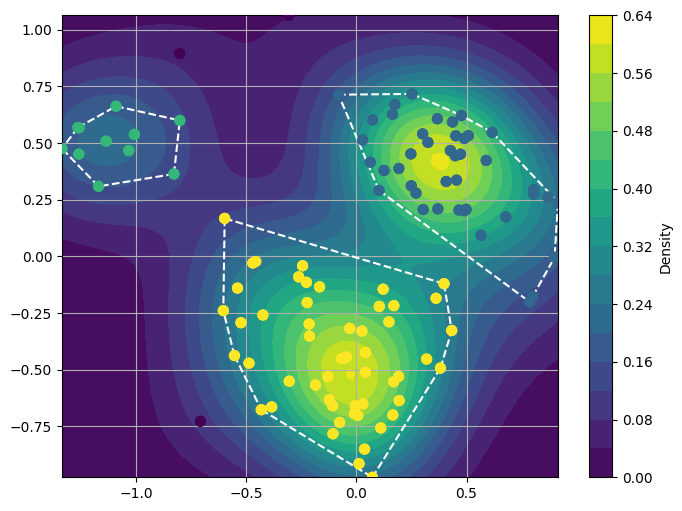

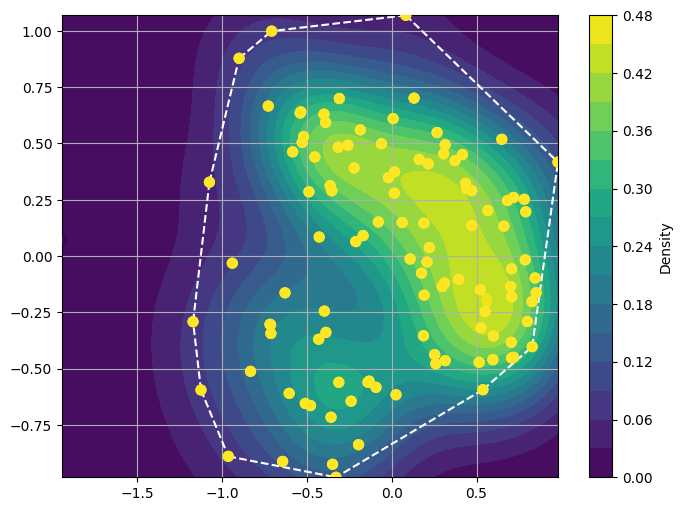

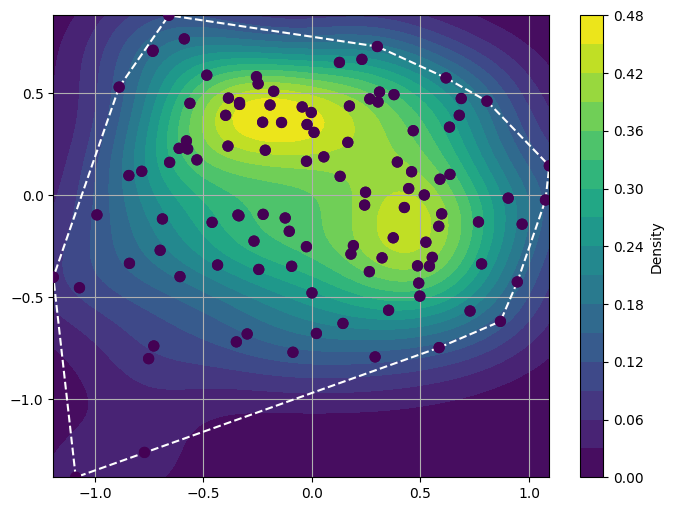

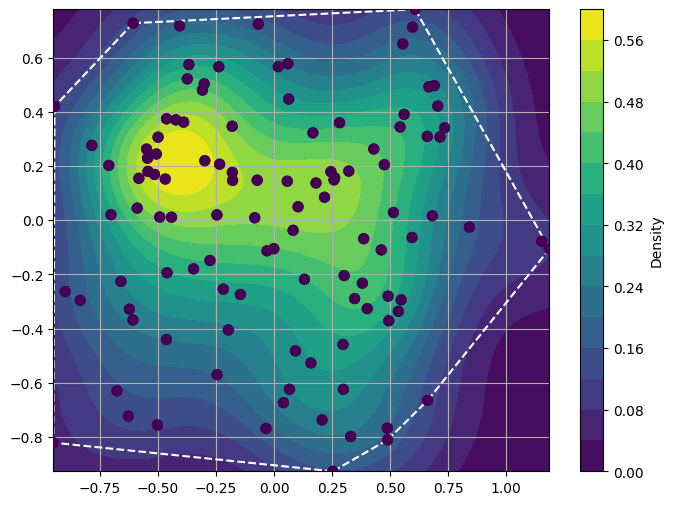

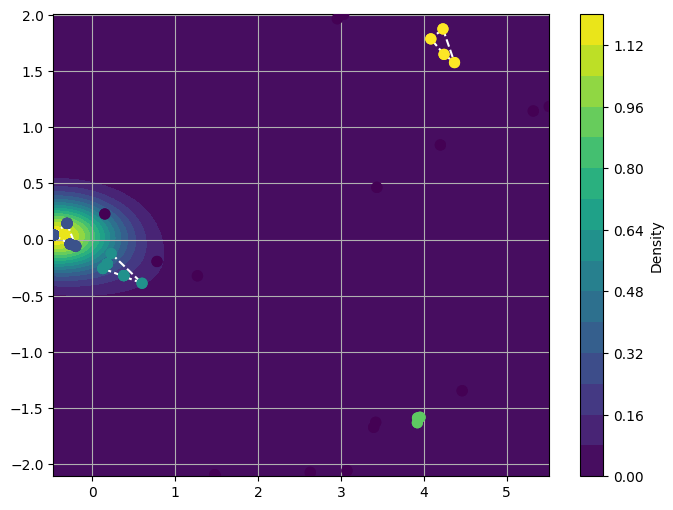

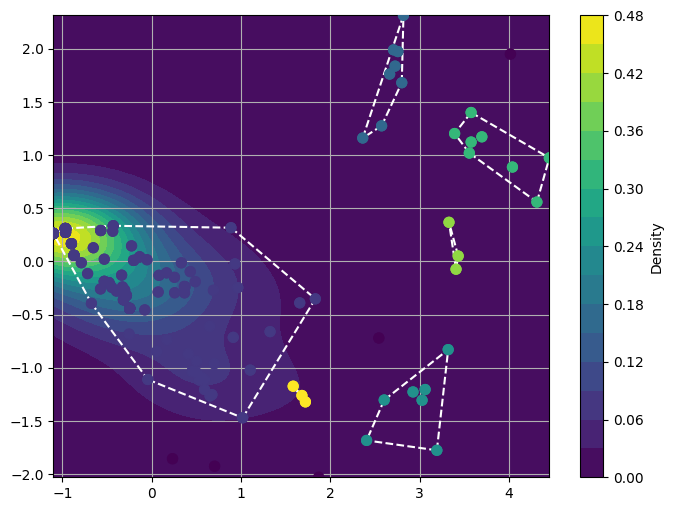

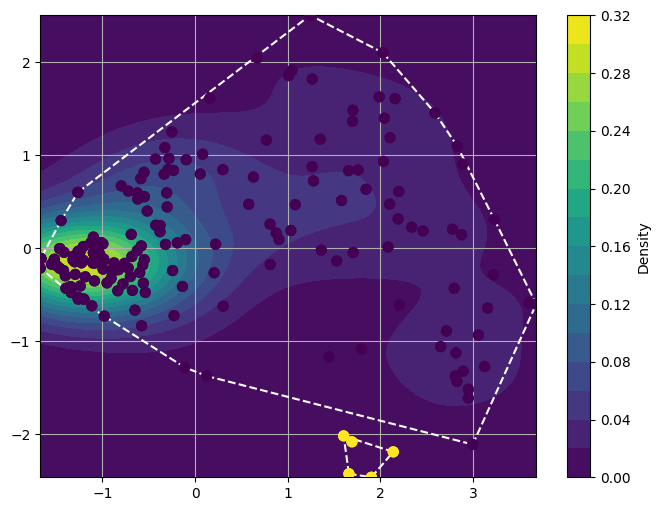

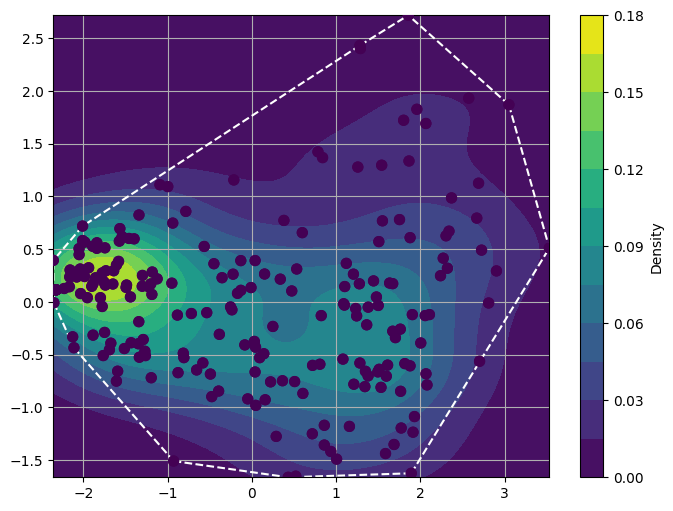

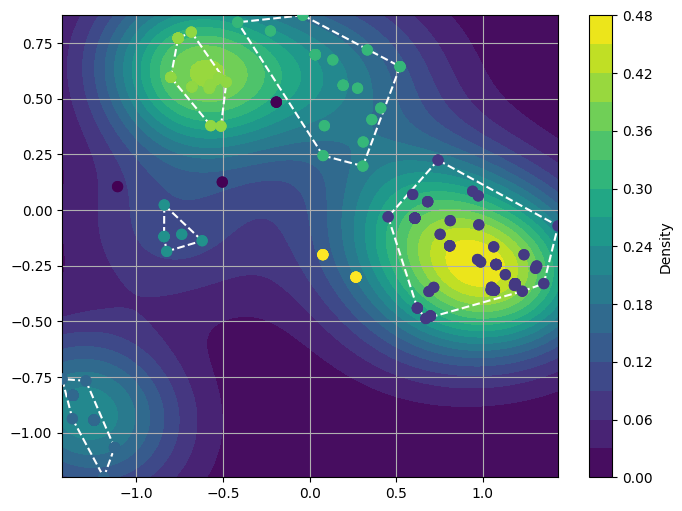

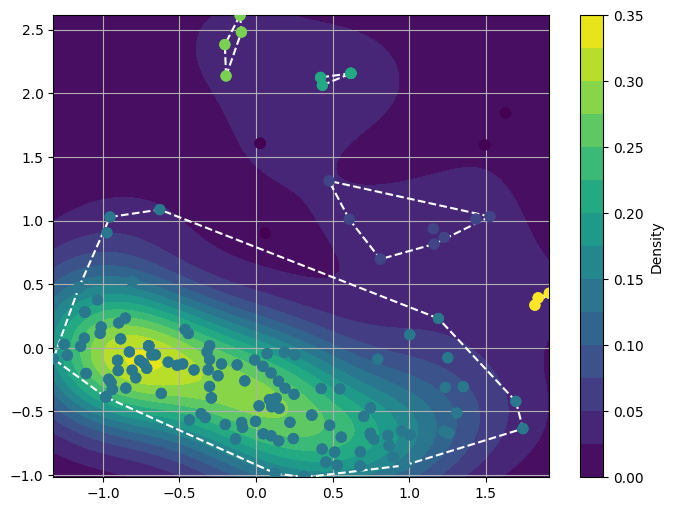

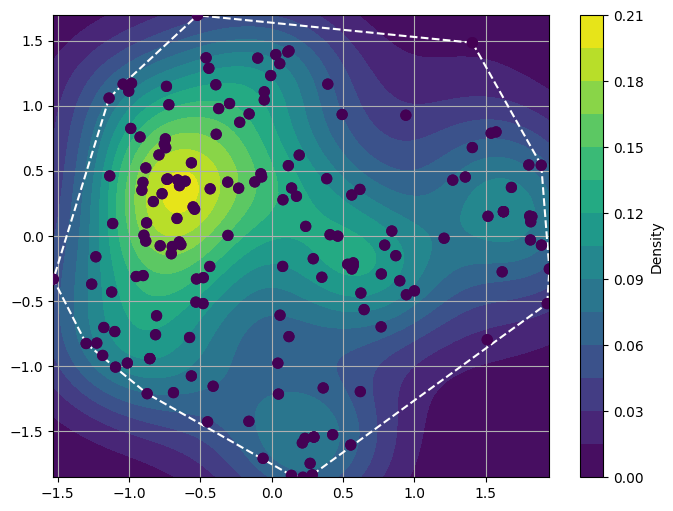

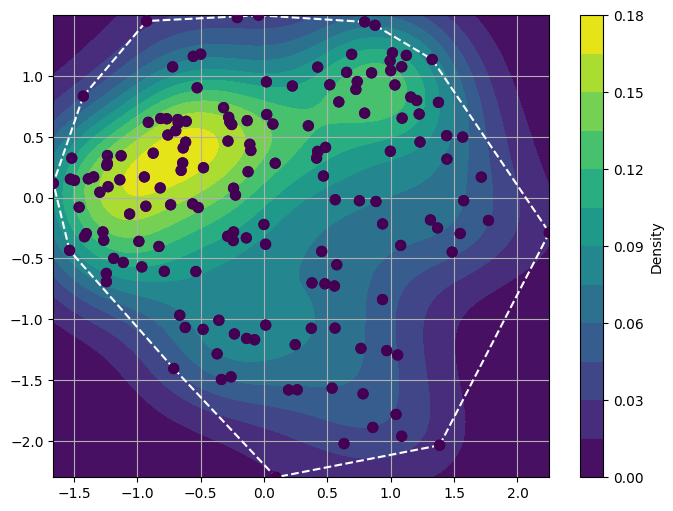

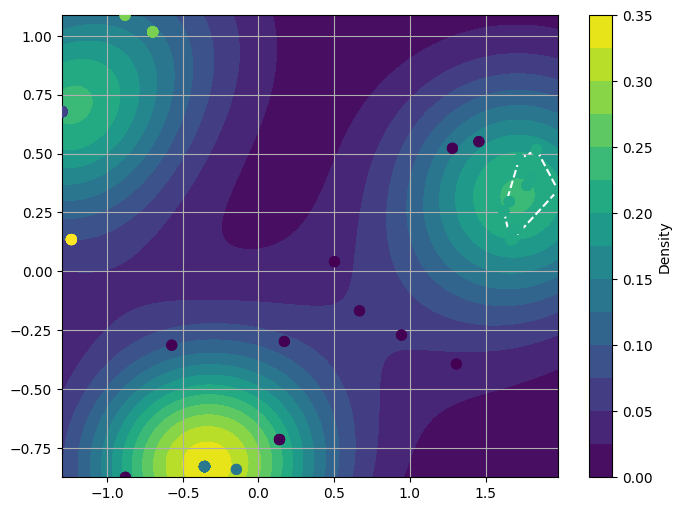

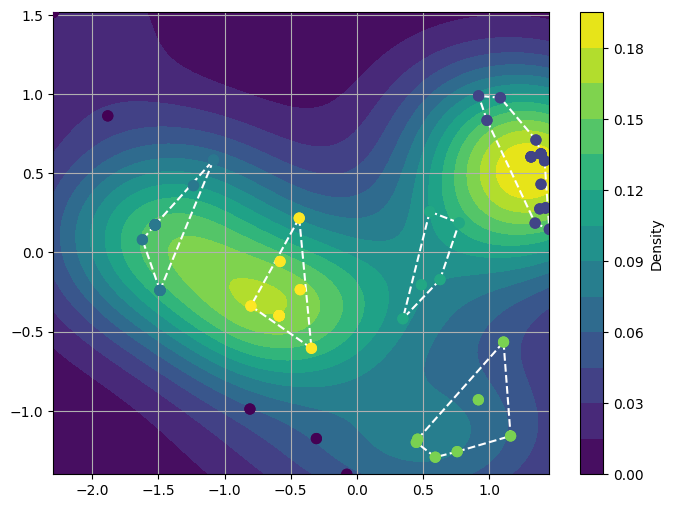

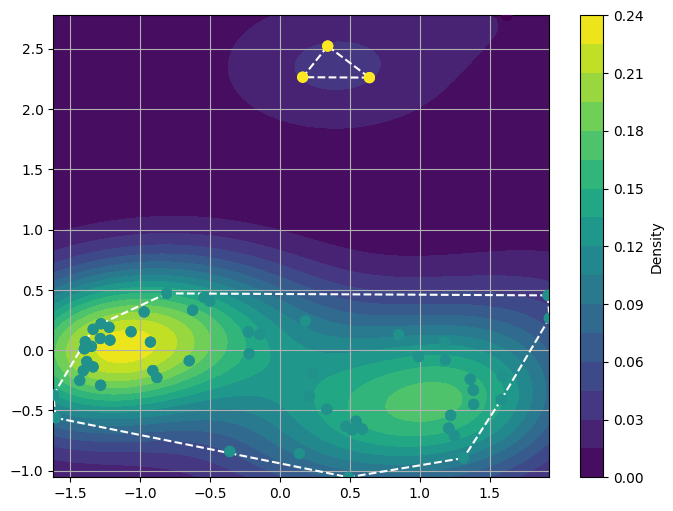

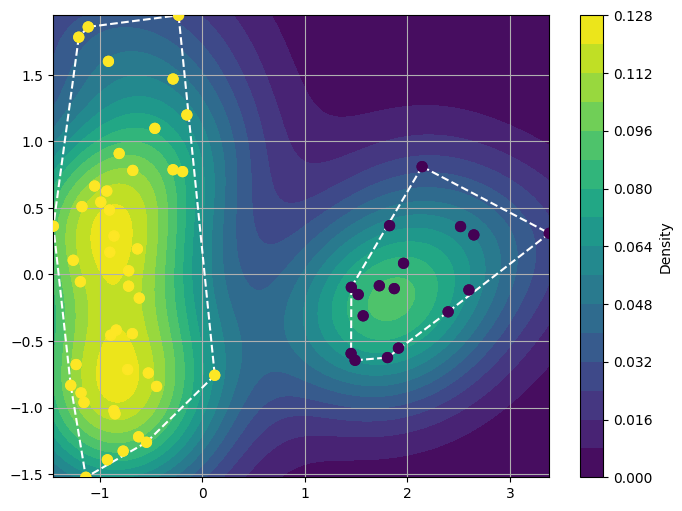

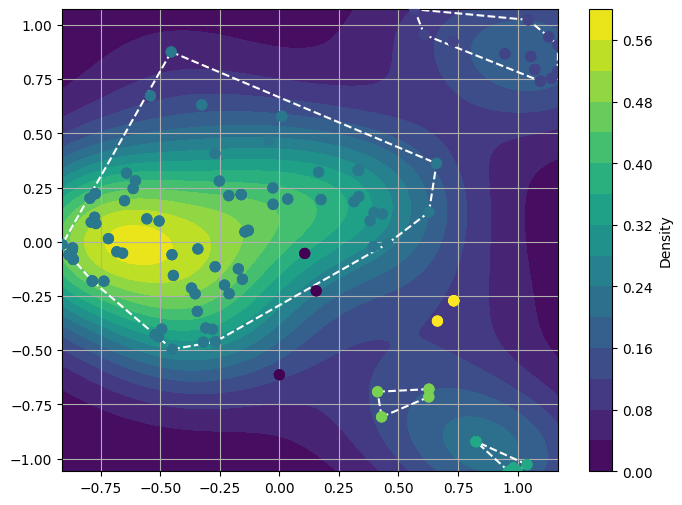

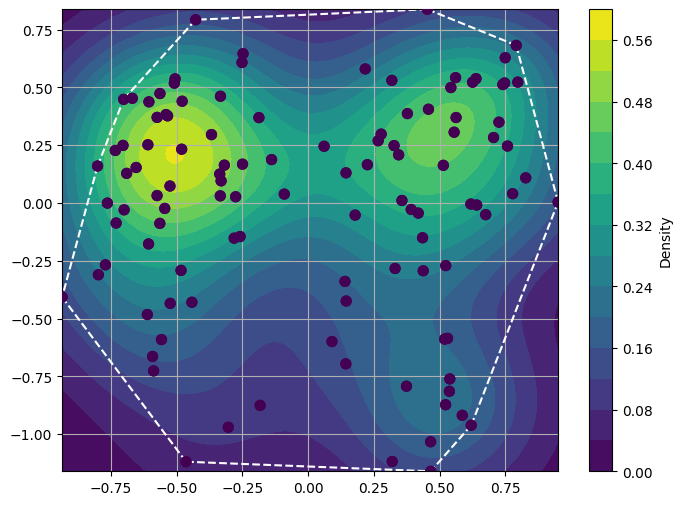

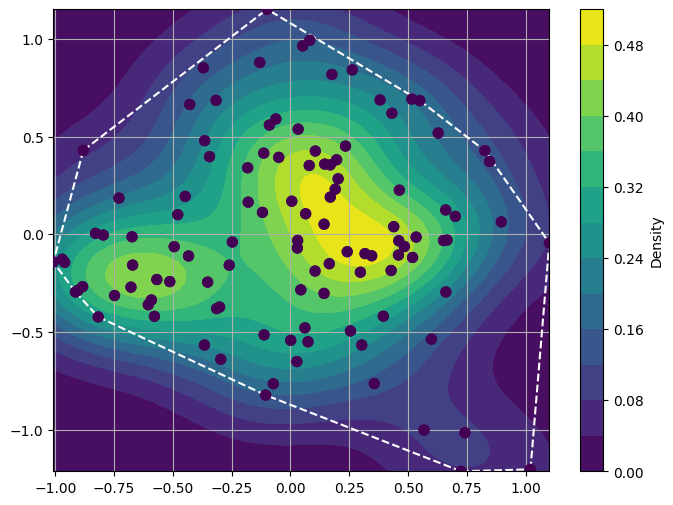

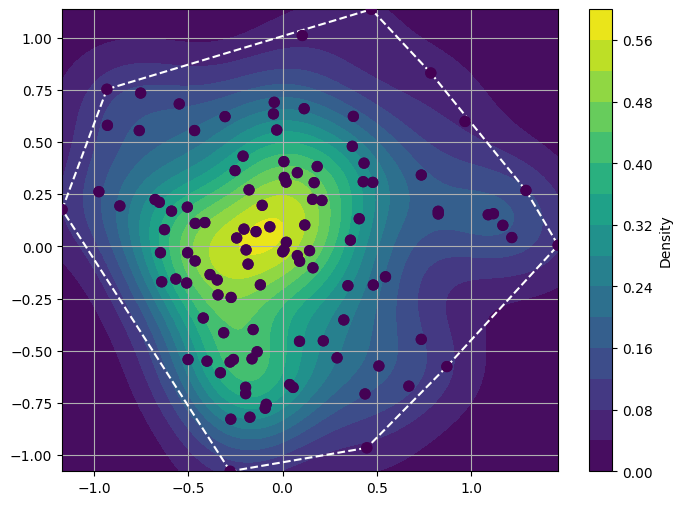

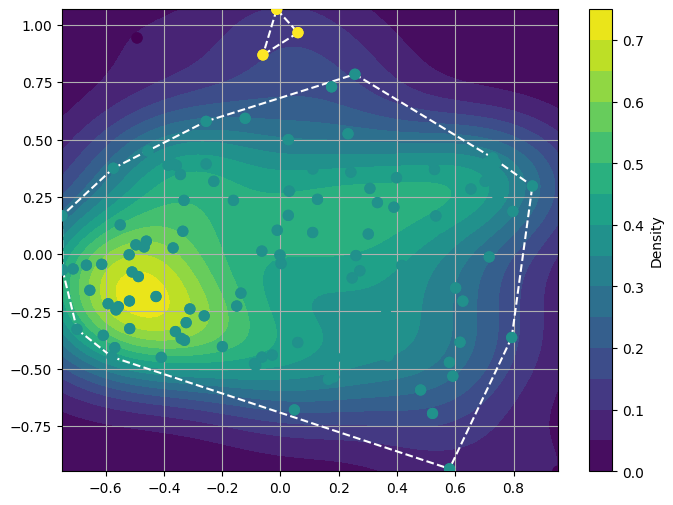

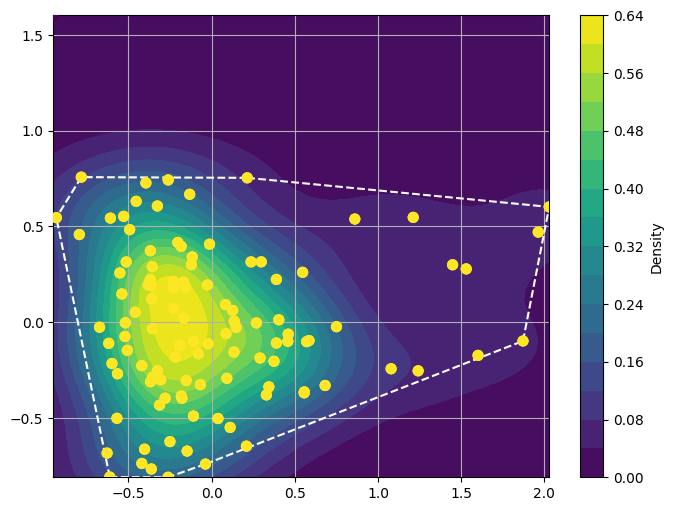

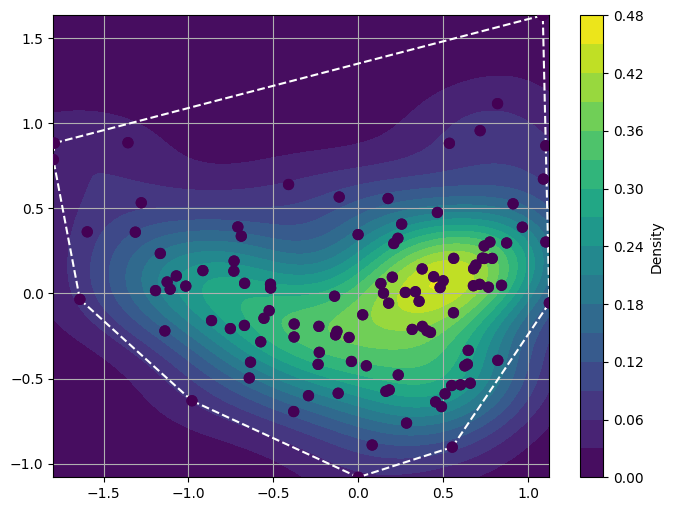

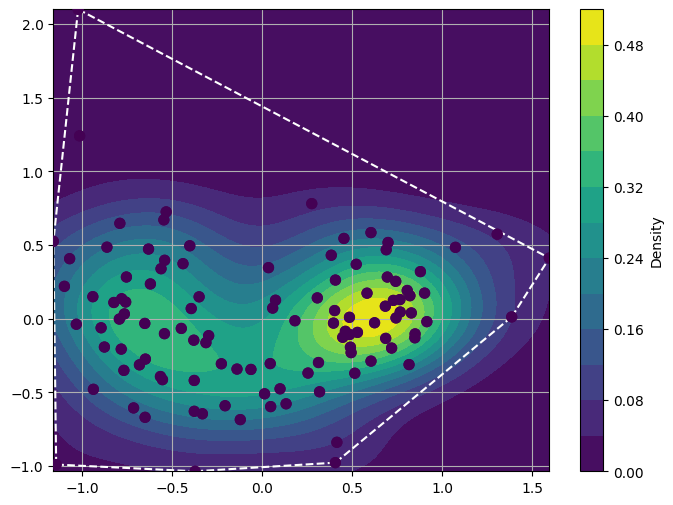

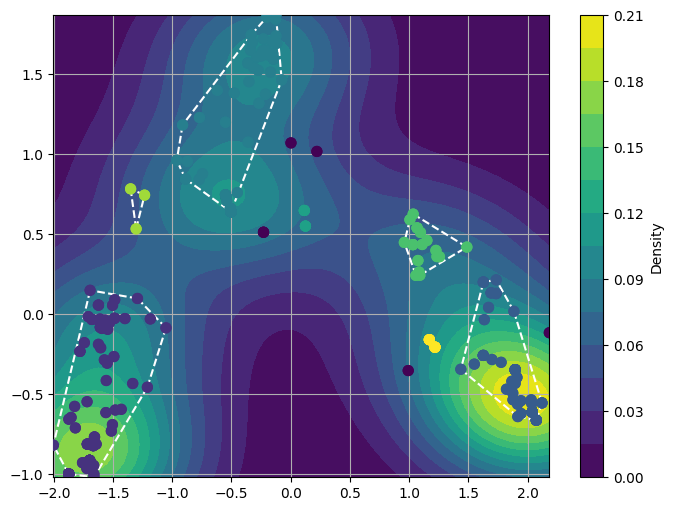

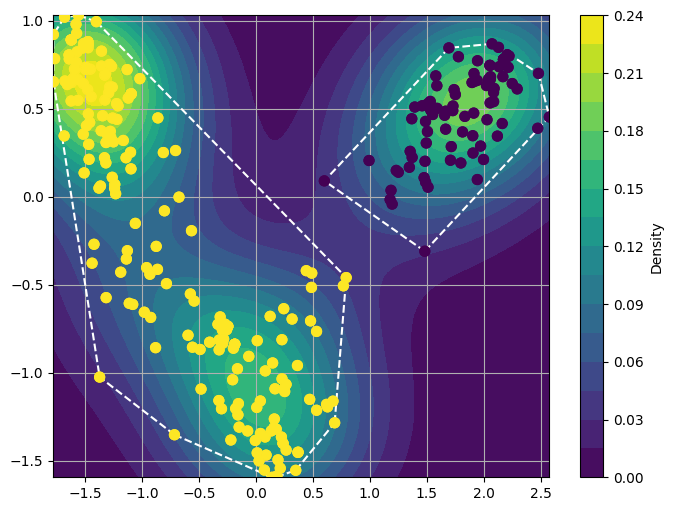

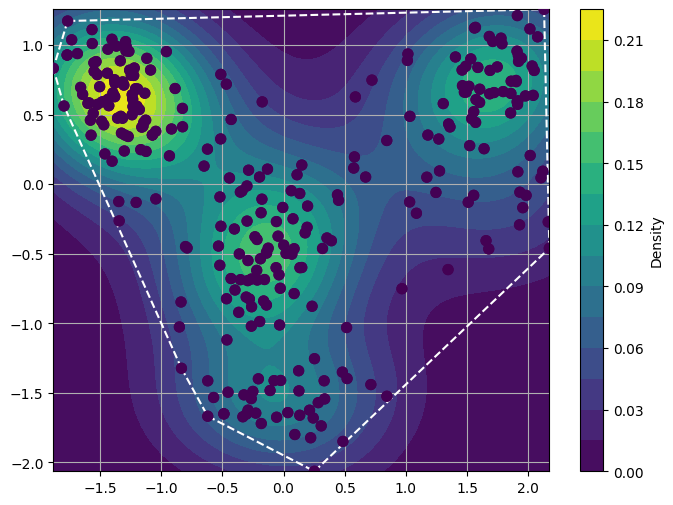

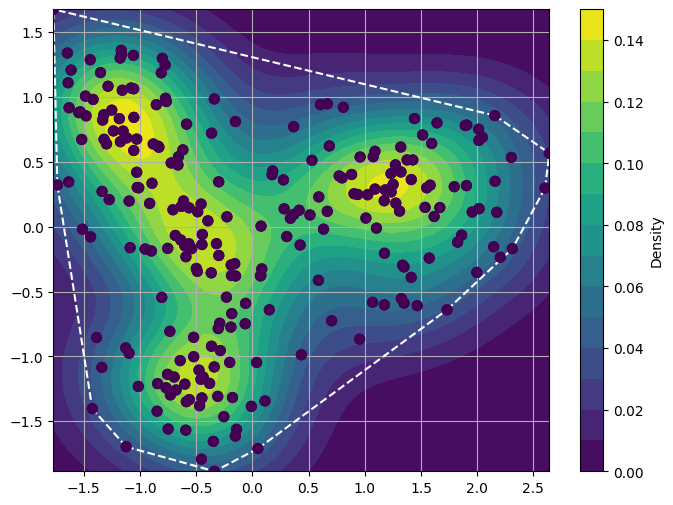

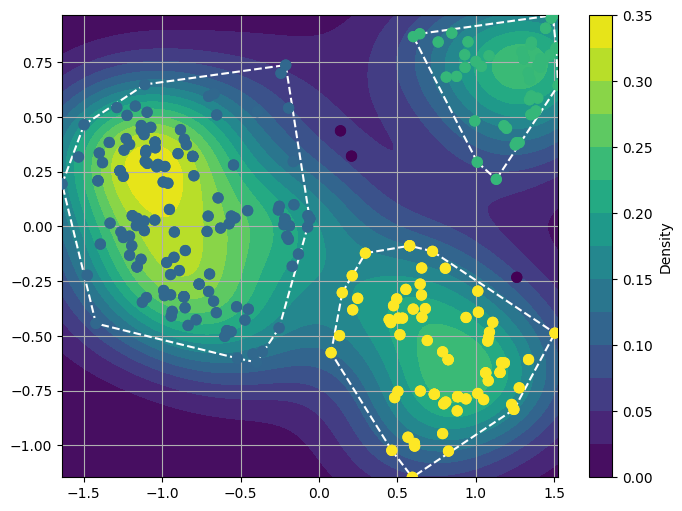

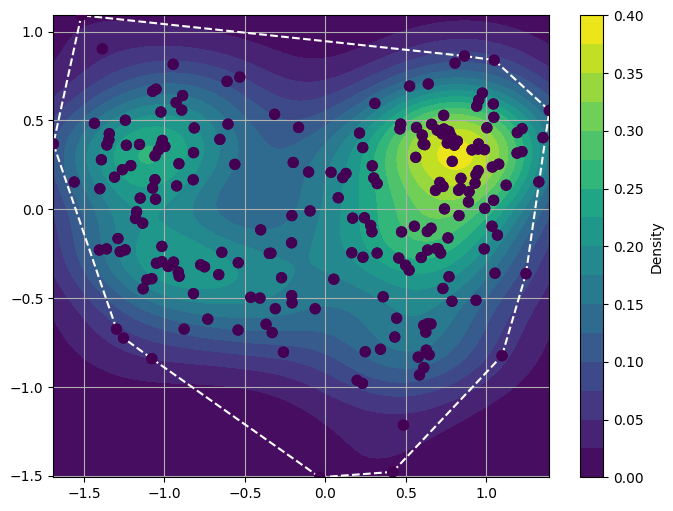

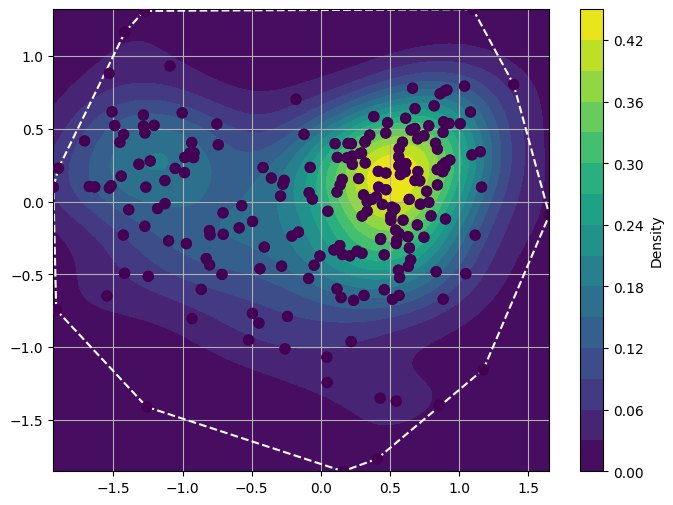

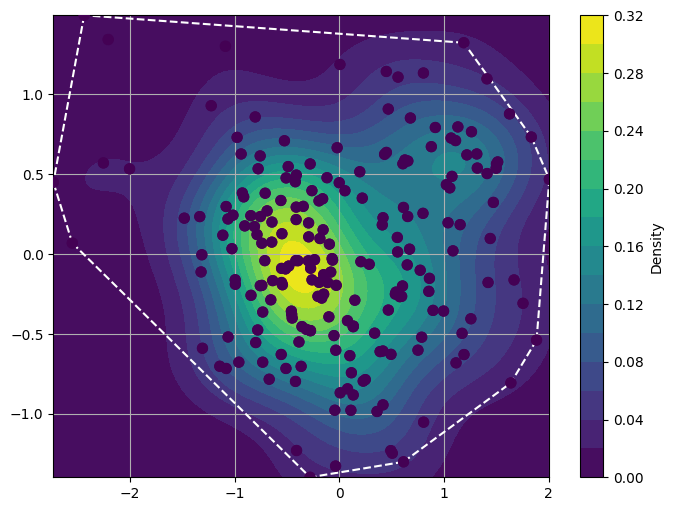

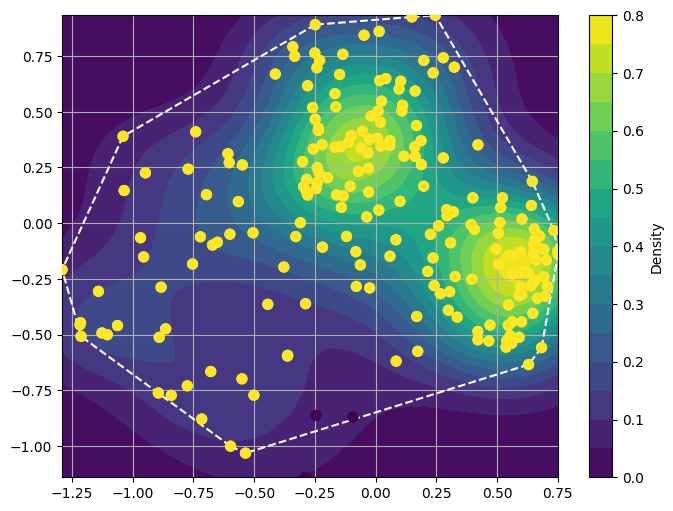

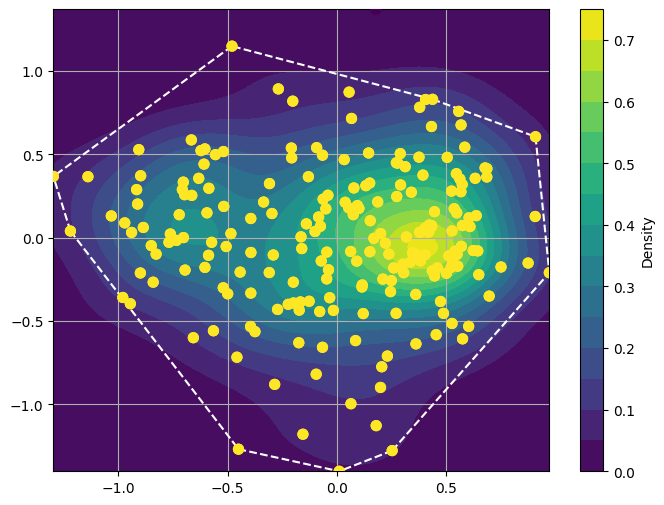

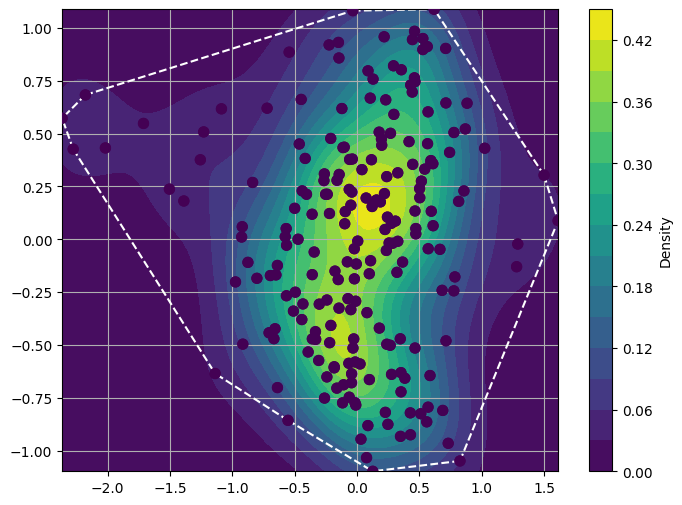

KeyboardInterrupt: 

In [12]:
# Extracting prompts from categorized_prompts
confusing_prompts = categorized_prompts['confusing']

# Initialize DataFrame to store results
columns = ['PromptID', 'PromptType', 'Model Name', 'Num_Clusters', 'Cluster_Areas'] + [f'Convex_Hull-{t}' for t in temperatures]
results_df = pd.DataFrame(columns=columns)

# Initialize an empty list to collect rows
rows = []

for gpt_model in tqdm(gpt_models):
    for prompt in tqdm(confusing_prompts, position=0, leave=True):
        row = {'PromptID': generate_unique_id(prompt), 'PromptType': 'confusing', 'Model Name': gpt_model}

        for temperature in temperatures:
            responses = get_responses_for_prompt(prompt, 'confusing', gpt_model, temperature)
            if not responses:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            embeddings = np.array([get_bert_embeddings(response) for response in responses])

            if embeddings.shape[0] < 10:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            # Dimensionality Reduction
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings)

            if embeddings_2d.shape[0] < 10:
                row[f'Convex_Hull-{temperature}'] = None
                continue

            # Clustering with DBSCAN
            dbscan = DBSCAN(eps=0.25 * temperature * 4.0, min_samples=3)
            # dbscan = DBSCAN(eps=5.0, min_samples=3)
            labels = dbscan.fit_predict(embeddings_2d)

            unique_labels = set(labels)
            hull_volumes = []
            total_hull_area = 0
            num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            
            if PLOT_FIGURES:
                plt.figure(figsize=(8, 6))
                plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', zorder=10, s=50)

                # Calculate the point density
                x = embeddings_2d[:, 0]
                y = embeddings_2d[:, 1]
                xy = np.vstack([x, y])
                z = gaussian_kde(xy)(xy)

                # Create a contour plot
                xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
                xi, yi = np.meshgrid(xi, yi)
                zi = gaussian_kde(xy)(np.vstack([xi.flatten(), yi.flatten()]))

                plt.contourf(xi, yi, zi.reshape(xi.shape), levels=15, cmap='viridis')
                plt.colorbar(label='Density')

                plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', zorder=10, s=50)


            for label in unique_labels:
                if label == -1:
                    continue
                cluster_indices = [idx for idx, l in enumerate(labels) if l == label]
                cluster_points = embeddings_2d[cluster_indices]

                if len(np.unique(cluster_points.round(5), axis=0)) > 2:
                    hull = ConvexHull(cluster_points)
                    hull_area = hull.volume
                    hull_volumes.append(hull_area)
                    total_hull_area += hull_area
                    if PLOT_FIGURES:
                        for simplex in hull.simplices:
                            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'w--')

            if PLOT_FIGURES:
                hull_volumes_str = ', '.join(f'Cluster {label}: {volume:.2f}' for label, volume in zip(unique_labels, hull_volumes) if label != -1)
                #plt.title(f'Convex Hulls for Clusters\nImage: {image}\n{hull_volumes_str}\nTotal Area: {total_hull_area:.2f}')
                #plt.xlabel('Component 1')
                #plt.ylabel('Component 2')
                plt.grid(True)
                plt.savefig(f"img/{generate_unique_id(prompt)}-{temperature}-hull.pdf",bbox_inches='tight')
                plt.show()

            row[f'Convex_Hull-{temperature}'] = total_hull_area

        row['Num_Clusters'] = num_clusters
        row['Cluster_Areas'] = hull_volumes
        rows.append(row)

# Concatenate rows into a DataFrame
results_df = pd.concat([results_df, pd.DataFrame(rows)], ignore_index=True)

# Save results to a CSV file
results_df.to_csv('convex_hull_results-confusing.csv', index=False)

In [ ]:
np.unique(cluster_points.round(5), axis=0)

In [ ]:
prompt

In [ ]:
results_df

In [ ]:
results_df = pd.read_csv('convex_hull_results-confusing.csv')#, index=False)
# Convert DataFrame to long format
results_long_df = pd.melt(results_df, id_vars=['PromptID', 'PromptType', 'Model Name', 'Num_Clusters', 'Cluster_Areas'], 
                          var_name='Temperature', value_name='Convex_Hull')

# Extract the temperature values from the column names
results_long_df['Temperature'] = results_long_df['Temperature'].str.extract(r'Convex_Hull-(.*)').astype(float)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_long_df, x='Temperature', y='Convex_Hull', hue='Model Name', marker='o')

#plt.title('Convex Hull Volume vs Temperature')
plt.xlabel('Temperature', fontsize=20)
plt.ylabel('Uncertainty Value', fontsize=20)
legend = plt.legend(title='Prompt ID', bbox_to_anchor=(0.01, 1), loc='upper left', fontsize="20")
plt.setp(legend.get_title(),fontsize=20)
#plt.ylim(0,11)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('confusing-unc.pdf', bbox_inches='tight')
plt.show()


In [ ]:
results_long_df

In [ ]:
for matrix_row in embeddings:
    print('[' + ' '.join(map(str, matrix_row[:3].round(3))) + ' ... ' + ' '.join(map(str, matrix_row[-3:].round(3))) + ']')

In [ ]:
generate_unique_id('Explain the process of photosynthesis in detail.')

In [ ]:
# Extracting prompts from categorized_prompts
confusing_prompts = categorized_prompts['confusing'][0:1]

# Initialize an empty list to collect rows
rows = []

for prompt in tqdm(confusing_prompts, position=0, leave=True):
    row = {'PromptID': hash(prompt), 'PromptType': 'confusing', 'Model Name': 'gpt-3.5-turbo'}
    
    for temperature in tqdm(temperatures):
        responses = get_responses_for_prompt(prompt, 'confusing', 'gpt-3.5-turbo', temperature)
        if not responses:
            # print(f"No responses available for prompt: {prompt} and temperature:{temperature}")
            row[f'Convex_Hull-{temperature}'] = None
            continue

        embeddings = np.array([get_bert_embeddings(response) for response in responses])
        
        if embeddings.shape[0] < 10:
            # print(f"Not enough responses available for prompt: {prompt} and temperature:{temperature}")
            row[f'Convex_Hull-{temperature}'] = None
            continue
            
        # Dimensionality Reduction
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        if embeddings_2d.shape[0] < 10:
            # print(f"Not enough responses available for prompt: {prompt} and temperature:{temperature}")
            row[f'Convex_Hull-{temperature}'] = None
            continue
            
        # Clustering with DBSCAN
        dbscan = DBSCAN(eps=0.25 * temperature * 4.0, min_samples=3)  # Adjust eps and min_samples based on your data scale and density
        labels = dbscan.fit_predict(embeddings_2d)
        
        # Identify the densest cluster (the one with the most points)
        if len(set(labels)) > 0:  # Check if we have clusters
            largest_cluster = max(set(labels), key=list(labels).count)
            cluster_indices = [idx for idx, label in enumerate(labels) if label == largest_cluster]
            cluster_points = embeddings_2d[cluster_indices]
        else:
            # print(f"No significant clusters found for prompt: {prompt} and temperature:{temperature}")
            row[f'Convex_Hull-{temperature}'] = None
            continue
        
        # Compute Convex Hull for the densest cluster's points
        if len(np.unique(cluster_points, axis=0)) > 2:  # At least 3 points to form a polygon
            hull = ConvexHull(cluster_points)
            row[f'Convex_Hull-{temperature}'] = hull.volume

            # Optional: Plotting
            if PLOT_FIGURES:
                plt.figure(figsize=(4, 3))
                for simplex in hull.simplices:
                    plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-')
                plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], 'b', alpha=0.1)
                plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='b', zorder=10)
                plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color='r', zorder=20)
                plt.title(f'Convex Hull of Densest Cluster: {hull.volume:.2f}')
                plt.xlabel('Component 1')
                plt.ylabel('Component 2')
                plt.grid(True)
                plt.show()


In [ ]:
# Extracting prompts from categorized_prompts
confusing_prompts = categorized_prompts['confusing'][2:3]

# Initialize an empty list to collect rows
rows = []

for prompt in tqdm(confusing_prompts, position=0, leave=True):
    row = {'PromptID': hash(prompt), 'PromptType': 'confusing', 'Model Name': 'gpt-3.5-turbo'}
    
    for temperature in tqdm(temperatures):
        responses = get_responses_for_prompt(prompt, 'confusing', 'gpt-3.5-turbo', temperature)
        if not responses:
            # print(f"No responses available for prompt: {prompt} and temperature:{temperature}")
            row[f'Convex_Hull-{temperature}'] = None
            continue

        embeddings = np.array([get_bert_embeddings(response) for response in responses])
        
        if embeddings.shape[0] < 10:
            # print(f"Not enough responses available for prompt: {prompt} and temperature:{temperature}")
            row[f'Convex_Hull-{temperature}'] = None
            continue
            
        # Dimensionality Reduction
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        if embeddings_2d.shape[0] < 10:
            # print(f"Not enough responses available for prompt: {prompt} and temperature:{temperature}")
            row[f'Convex_Hull-{temperature}'] = None
            continue
            
        # Clustering with DBSCAN
        dbscan = DBSCAN(eps=0.25 * temperature * 4.0, min_samples=3)  # Adjust eps and min_samples based on your data scale and density
        labels = dbscan.fit_predict(embeddings_2d)
        
        # Plot all clusters and their convex hulls
        plt.figure(figsize=(8, 6))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', zorder=10, s=50)
        
        unique_labels = set(labels)
        hull_volumes = []
        total_hull_area = 0
        for label in unique_labels:
            if label == -1:
                # -1 is noise in DBSCAN
                continue
            cluster_indices = [idx for idx, l in enumerate(labels) if l == label]
            cluster_points = embeddings_2d[cluster_indices]
            
            if len(np.unique(cluster_points, axis=0)) > 2:  # At least 3 points to form a polygon
                hull = ConvexHull(cluster_points)
                hull_area = hull.volume
                row[f'Convex_Hull-{temperature}-{label}'] = hull_area
                hull_volumes.append(hull_area)
                total_hull_area += hull_area
                for simplex in hull.simplices:
                    plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-')
                plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], alpha=0.3)
        
        hull_volumes_str = ', '.join(f'Cluster {label}: {volume:.2f}' for label, volume in zip(unique_labels, hull_volumes) if label != -1)
        plt.title(f'Convex Hulls for Clusters at Temperature {temperature}\nPrompt: {prompt}\n{hull_volumes_str}\nTotal Area: {total_hull_area:.2f}')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()